# Two Sigma: Rental Interest Competition

In [1]:
import datetime
import itertools
import json
import operator
import os
import pandas as pd
import pickle
import pprint
import numpy as np
import re
import spacy
import torch
import torch.optim as optim

from collections import Counter, deque
from pytorch_pretrained_bert import BertAdam
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    mean_squared_error
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skorch.callbacks import (
    Callback,
    Checkpoint,
    EpochScoring,
    LRScheduler,
    ProgressBar,
    TrainEndCheckpoint
)

from utils.data import load_training_test_data
from utils.dataframe import (
    categories_from_column,
    column_list_to_category_flags,
    count_json_in_dataframes,
    count_ngrams_up_to_n,
    drop_columns_from_dataframes,
    map_categorical_column_to_category_ids,
    normalize_categories,
    normalize_description,
    numerical_feature_engineering_on_dataframe,
    parse_address_components,
    remap_column,
    remap_columns_with_transform,
    remap_date_column_to_days_before,
    remove_small_or_stopwords_from_ranking
)
from utils.doc2vec import (
    column_to_doc_vectors
)
from utils.model import (
    basic_logistic_regression_pipeline,
    basic_xgboost_pipeline,
    expand_onehot_encoding,
    format_statistics,
    get_prediction_probabilities_with_columns,
    get_prediction_probabilities_with_columns_from_predictions,
    prediction_accuracy,
    write_predictions_table_to_csv,
    rescale_features_and_split_into_continuous_and_categorical,
    split_into_continuous_and_categorical,
    test_model_with_k_fold_cross_validation
)
from utils.language_models.bert import (
    BertClassifier,
    BertForSequenceClassification,
    GRADIENT_ACCUMULATION_STEPS,
    LEARNING_RATE,
    TRAIN_BATCH_SIZE,
    WARMUP_PROPORTION,
    bert_featurize_data_frames,
    create_bert_model,
    create_bert_model_with_tabular_features
)
from utils.language_models.descriptions import (
    descriptions_to_word_sequences,
    generate_bigrams,
    generate_description_sequences,
    maybe_cuda,
    postprocess_sequences,
    token_dictionary_seq_encoder,
    tokenize_sequences,
    torchtext_create_text_vocab,
    torchtext_process_texts,
    words_to_one_hot_lookups,
)
from utils.language_models.fasttext import (
    FastText,
    FastTextWithTabularData
)
from utils.language_models.simple_rnn import (
    CheckpointAndKeepBest,
    LRAnnealing,
    NoToTensorInLossClassifier,
    SimpleRNNPredictor,
    SimpleRNNTabularDataPredictor
)
from utils.language_models.split import (
    shuffled_train_test_split_by_indices,
    simple_train_test_split_without_shuffle_func,
    ordered_train_test_split_with_oversampling
)
from utils.language_models.textcnn import (
    TextCNN,
    TextCNNWithTabularData
)
from utils.language_models.ulmfit import (
    load_ulmfit_classifier_with_transfer_learning_from_data_frame,
    train_ulmfit_classifier_with_gradual_unfreezing
)
from utils.report import (
    generate_classification_report_from_preds,
    generate_classification_report
)

nlp = spacy.load("en")

Check GPU support

In [2]:
torch.cuda.is_available()

True

## 1) Load data

In [3]:
(ALL_TRAIN_DATAFRAME, TEST_DATAFRAME) = \
  load_training_test_data(os.path.join('data', 'train.json'),
                          os.path.join('data', 'test.json'))
TRAIN_INDEX, VALIDATION_INDEX = train_test_split(ALL_TRAIN_DATAFRAME.index, test_size=0.1)
TRAIN_DATAFRAME = ALL_TRAIN_DATAFRAME.iloc[TRAIN_INDEX].reset_index()
VALIDATION_DATAFRAME = ALL_TRAIN_DATAFRAME.iloc[VALIDATION_INDEX].reset_index()
TEST_DATAFRAME = TEST_DATAFRAME.reset_index()

## 2) Data Cleaning

Let's see what this table looks like. We'll display the head of the table which shows its features

In [4]:
TRAIN_DATAFRAME.head()

,index,id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,31086,78098,1.0,1,0,2016-05-05 05:20:46,"1 BD MIDTOWN WEST/ HELLS KITCHEN , ,HARD WOOD ...",W 49th St.,"[Hardwood Floors, Outdoor Space]",40.7630,6969324,-73.9902,63ba8954e3cb79647d71eb0d56025039,[https://photos.renthop.com/2/6969324_2ea36203...,2485,412 W 49th St.,low
1,43279,108883,2.0,3,d9ecc11f7d634c492a93cbfaa310a71c,2016-04-06 03:00:13,Massive Flex 3BR/2BA apartment at an unbeatabl...,E 82nd St.,"[Balcony, Doorman, Elevator, Terrace, Laundry ...",40.7753,6829352,-73.9540,2983e45f7e0ad87d677dacd13e362785,[https://photos.renthop.com/2/6829352_8f7dace4...,5500,240 E 82nd St.,medium
2,17601,44332,4.5,4,41b3f5da3a9d25611fda51a320de54f4,2016-05-25 02:33:56,(((((((((((((((((2300SF)))))))))))))))))))))))...,W 86th St.,"[Roof Deck, Dining Room, Doorman, Elevator, Fi...",40.7860,7062909,-73.9703,7b73a97a2516d3c33de0d452f21d4e79,[https://photos.renthop.com/2/7062909_39fd7b10...,24000,21 W 86th St.,low
3,23229,58460,0.0,2,0,2016-05-25 20:36:04,,W 109th St,[],40.8030,7067407,-73.9664,5239c98c3c2228c0369842750684054d,[],2850,244 W 109th St,low
4,46117,115974,1.0,1,b24fe663839858ffc7a84410a20e1b9e,2016-04-12 04:25:17,This is why we leave Manhattan! This s...,Greenway Terrace,"[Doorman, Elevator, Cats Allowed, Dogs Allowed]",40.7164,6860155,-73.8439,fc3eb34da075c0a3835533f61f0851f9,[https://photos.renthop.com/2/6860155_b7442cc4...,2700,150 Greenway Terrace,low


### 2.1) Cleaning up categories

Let's clean up the categories and put them into a sensible vector. Unfortunately the categories are a bit of a mess - since the user can specify what categories they want there isn't much in the way of consistency between categories.

Some of the patterns that we frequently see in the categories are:
 - Separating category names with "**"
 - Mix of caps/nocaps
 - Some common themes, such as:
   - "pets"
   - "office"
   - "living room"
   - "garden"
   - "common area"
   - "storage"
   - "no pets"
   - "parking"
   - "bicycle"
   - "doorman"
   - etc

To deal with this, lets pull out all of the categories and normalize them
by removing excess punctuation, normalizing for whitespace, lowercasing, and counting for certain n-grams.

In [5]:
normalized_categories = sorted(normalize_categories(categories_from_column(TRAIN_DATAFRAME, 'features')))
normalized_categories[:50]

['$1500. move in visa giftcard will be handed to new tenants upon rental lease signing',
 '$250 application fee with background and credit check. board interview and approval.',
 '$250 security deposit',
 '$500 security deposit',
 '$600 gift card for move ins prior to june 19',
 '000 sf fitness center',
 '000 sq. ft. landscaped terrace complete with an organic garden',
 '000 square foot exclusive courtyard oasis for via residents',
 '000 square foot sun deck• free wifi in marc club',
 '1 br or conv 2',
 "1 mo broker's fee 18 mo lease",
 '1 month free',
 '1 month free',
 '1 month free',
 '1 month free rent',
 '1.5 bath',
 '1.5 bathrooms',
 '1.5 baths',
 '1.5 baths',
 '1.5 marble baths',
 '1/2 bath',
 '1/2 month fee',
 '1100 sq ft',
 '1200sq ft',
 '12th st 3rd ave',
 '1st',
 '2',
 '2 bathrooms',
 '2 beautifully furnished outside sundecks',
 '2 blocks away from union square',
 '2 full bathrooms',
 '2 full baths',
 '2 months free',
 '2 queen bedrooms',
 '2 story tenant lounge',
 '2 year le

Now that we have our slightly tidied up categories, we can create some n-grams and count their frequency

In [6]:
most_common_ngrams = sorted(count_ngrams_up_to_n(" ".join(normalized_categories), 3).most_common(),
                            key=lambda x: (-x[1], x[0]))
most_common_ngrams[:50]

[('', 5961),
 ('in', 110),
 ('kitchen', 108),
 ('room', 83),
 ('to', 83),
 ('home', 60),
 ('of', 60),
 ('fee', 58),
 ('no', 54),
 ('and', 52),
 ('the', 52),
 ('private', 51),
 ('super', 50),
 ('2br', 48),
 ('massive', 46),
 ('new', 46),
 ('2', 44),
 ('on', 43),
 ('storage', 42),
 ('park', 41),
 ('share', 41),
 ('windows', 41),
 ('no fee', 39),
 ('ok', 38),
 ('pets', 38),
 ('sprawling', 38),
 ('bldg', 37),
 ('deck', 37),
 ('laundry', 34),
 ('all', 33),
 ('l', 33),
 ('renovated', 32),
 ('roof', 32),
 ('free', 31),
 ('oversized', 31),
 ('parking', 31),
 ('3br', 30),
 ('huge', 30),
 ('eat', 28),
 ('eat in', 28),
 ('in kitchen', 28),
 ('with', 28),
 ('1br', 27),
 ('doorman', 27),
 ('steps', 27),
 ('studio', 27),
 ('blks', 26),
 ('blks to', 26),
 ('closets', 26),
 ('full', 26)]

There's quite a few words here that don't add much value. We can remove them by consulting a list of stopwords

In [7]:
most_common_ngrams = sorted(list(remove_small_or_stopwords_from_ranking(most_common_ngrams, nlp, 3)),
                            key=lambda x: (-x[1], x[0]))
most_common_ngrams[:50]

[('kitchen', 108),
 ('room', 83),
 ('home', 60),
 ('fee', 58),
 ('private', 51),
 ('super', 50),
 ('2br', 48),
 ('massive', 46),
 ('new', 46),
 ('storage', 42),
 ('park', 41),
 ('share', 41),
 ('windows', 41),
 ('no fee', 39),
 ('pets', 38),
 ('sprawling', 38),
 ('bldg', 37),
 ('deck', 37),
 ('laundry', 34),
 ('renovated', 32),
 ('roof', 32),
 ('free', 31),
 ('oversized', 31),
 ('parking', 31),
 ('3br', 30),
 ('huge', 30),
 ('eat', 28),
 ('eat in', 28),
 ('in kitchen', 28),
 ('1br', 27),
 ('doorman', 27),
 ('steps', 27),
 ('studio', 27),
 ('blks', 26),
 ('blks to', 26),
 ('closets', 26),
 ('included', 26),
 ('large', 26),
 ('steps to', 26),
 ('super share', 26),
 ('lounge', 25),
 ('on site', 25),
 ('site', 25),
 ('clean', 24),
 ('pets ok', 24),
 ('roof deck', 24),
 ('appliances', 23),
 ('bedford', 23),
 ('bedford l', 23),
 ('brick', 23)]

Now that we have these, we can probably take 100 most common and arrange
them into category flags for our table

In [8]:
TRAIN_DATAFRAME = column_list_to_category_flags(TRAIN_DATAFRAME, 'features', list(map(operator.itemgetter(0), most_common_ngrams[:100])))
VALIDATION_DATAFRAME = column_list_to_category_flags(VALIDATION_DATAFRAME, 'features', list(map(operator.itemgetter(0), most_common_ngrams[:100])))
TEST_DATAFRAME = column_list_to_category_flags(TEST_DATAFRAME, 'features', list(map(operator.itemgetter(0), most_common_ngrams[:100])))

In [9]:
TRAIN_DATAFRAME.head(5)

,index,id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,...,features_heart_of,features_in_unit,features_living,features_luxury,features_natural,features_steel,features_true,features_views,features_approved,features_ave
0,31086,78098,1.0,1,0,2016-05-05 05:20:46,"1 BD MIDTOWN WEST/ HELLS KITCHEN , ,HARD WOOD ...",W 49th St.,"[Hardwood Floors, Outdoor Space]",40.7630,...,0,0,0,0,0,0,0,0,0,0
1,43279,108883,2.0,3,d9ecc11f7d634c492a93cbfaa310a71c,2016-04-06 03:00:13,Massive Flex 3BR/2BA apartment at an unbeatabl...,E 82nd St.,"[Balcony, Doorman, Elevator, Terrace, Laundry ...",40.7753,...,0,0,0,0,0,0,0,0,0,0
2,17601,44332,4.5,4,41b3f5da3a9d25611fda51a320de54f4,2016-05-25 02:33:56,(((((((((((((((((2300SF)))))))))))))))))))))))...,W 86th St.,"[Roof Deck, Dining Room, Doorman, Elevator, Fi...",40.7860,...,0,1,0,0,0,0,0,0,0,0
3,23229,58460,0.0,2,0,2016-05-25 20:36:04,,W 109th St,[],40.8030,...,0,0,0,0,0,0,0,0,0,0
4,46117,115974,1.0,1,b24fe663839858ffc7a84410a20e1b9e,2016-04-12 04:25:17,This is why we leave Manhattan! This s...,Greenway Terrace,"[Doorman, Elevator, Cats Allowed, Dogs Allowed]",40.7164,...,0,0,0,0,0,0,0,0,0,0


### 2.2) Cleaning up listing_date

We can also do something useful with the listing date - it may be better to say how many days ago the property was listed - older properties are probably going to get a lot less interest than newer properties.

In [10]:
TRAIN_DATAFRAME = remap_date_column_to_days_before(TRAIN_DATAFRAME, "created", "created_days_ago", datetime.datetime(2017, 1, 1))
VALIDATION_DATAFRAME = remap_date_column_to_days_before(VALIDATION_DATAFRAME, "created", "created_days_ago", datetime.datetime(2017, 1, 1))
TEST_DATAFRAME = remap_date_column_to_days_before(TEST_DATAFRAME, "created", "created_days_ago", datetime.datetime(2017, 1, 1))

In [11]:
TRAIN_DATAFRAME["created_days_ago"].head(5)

0    240
1    269
2    220
3    220
4    263
Name: created_days_ago, dtype: int64

### 2.3) Cleaning up interest_level

Right now the interest level is encoded on a scale of "Low, Medium, High". The competition
wants us to classify the entries in to each, so we assign a label

In [12]:
INTEREST_LEVEL_MAPPINGS = {
    "high": 0,
    "medium": 1,
    "low": 2
}

TRAIN_DATAFRAME = remap_column(TRAIN_DATAFRAME, "interest_level", "label_interest_level", lambda x: INTEREST_LEVEL_MAPPINGS[x])
VALIDATION_DATAFRAME = remap_column(VALIDATION_DATAFRAME, "interest_level", "label_interest_level", lambda x: INTEREST_LEVEL_MAPPINGS[x])
# The TEST_DATAFRAME does not have an interest_level column, so we
# instead add it and replace it with all zeros
TEST_DATAFRAME["label_interest_level"] = 0

In [13]:
TRAIN_DATAFRAME["label_interest_level"].head(5)

0    2
1    1
2    2
3    2
4    2
Name: label_interest_level, dtype: int64

### 2.4) Cleaning up building_id, manager_id

`building_id` and `manager_id` look a bit useless to us on the outside, but according to https://www.kaggle.com/den3b81/some-insights-on-building-id they are actually quite predictive of interest since 20% of the manager make up 80% of the rentals (we can also see this in their writing style as well).

Since there aren't too many managers or buildings in total, we can convert these into category ID's where we'll pass them through an embedding later on.

Note that we need to do this over both dataframes - since there could
be some managers that are in the test dataframe which are not in the training dataframe and vice versa.

Note that we want to lump all the "misc" buildings and managers together
into a single building or manager since listings by "non-property managers" or "non-frequently-rented-buildings" are different from ones run by property managers.

In [14]:
((BUILDING_ID_UNKNOWN_REMAPPING,
  BUILDING_CATEGORY_TO_BUILDING_ID,
  BUILDING_CATEGORY_TO_BUILDING_ID),
 (TRAIN_DATAFRAME,
  VALIDATION_DATAFRAME,
  TEST_DATAFRAME)) = map_categorical_column_to_category_ids(
    'building_id',
    'building_id_category',
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
    min_freq=40
)

In [15]:
((MANAGER_ID_UNKNOWN_REMAPPING,
  MANAGER_ID_TO_MANAGER_CATEGORY,
  MANAGER_CATEGORY_TO_MANAGER_ID),
 (TRAIN_DATAFRAME,
  VALIDATION_DATAFRAME,
  TEST_DATAFRAME)) = map_categorical_column_to_category_ids(
    'manager_id',
    'manager_id_category',
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
    min_freq=40
)

### 2.4AA) Parsing and Separating Out Address Components
Some properties might be in the same neighbourhood, the same street or
part of the same building. If we separate out the address components then
we might be able to get some more meaningful feature groupings.

We first parse all the components into their own columns and then map them into categories (dropping them later on).

In [16]:
(TRAIN_DATAFRAME,
 VALIDATION_DATAFRAME,
 TEST_DATAFRAME) = parse_address_components(
    [
        "display_address",
        "street_address"
    ],
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
)

In [17]:
((DISP_ADDR_ID_UNKNOWN_REMAPPING,
  DISP_ADDR_ID_TO_DISP_ADDR_CATEGORY,
  DISP_ADDR_CATEGORY_TO_DISP_ADDR_ID),
 (TRAIN_DATAFRAME,
  VALIDATION_DATAFRAME,
  TEST_DATAFRAME)) = map_categorical_column_to_category_ids(
    'display_address_normalized',
    'display_address_category',
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
    min_freq=40
)

### 2.4AB) Counting Number of Photos
The number of photos a place has might be predictive of its interest as well, so lets at least count the number of photos.

In [18]:
(TRAIN_DATAFRAME,
 VALIDATION_DATAFRAME,
 TEST_DATAFRAME) = count_json_in_dataframes(
    "photos",
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
)

### 2.4AC) Feature Engineering on Numerical Columns
Some models can't do simple math, but ratios or additions/subtractions
between things might be important. Lets do that now for all of our
numerical data, but only for XGBoost, later

In [19]:
NUMERICAL_COLUMNS = [
    'bathrooms',
    'bedrooms',
    'price',
    'latitude',
    'longitude',
    'photos_count'
]

### 2.4A) Generating document vectors for description
The text in the descriptions are pretty messy. We can generate some document vectors to embed the entire thing into vector space.

To do that we use an LSTM to train some embeddings, similar to the Tweet2Vec paper.

In [20]:
(TRAIN_DATAFRAME,
 VALIDATION_DATAFRAME,
 TEST_DATAFRAME) = remap_columns_with_transform(
    'description',
    'clean_description',
    normalize_description,
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
)

In [21]:
#TRAIN_DATAFRAME, TEST_DATAFRAME = utils.doc2vec.column_to_doc_vectors(
#    TRAIN_DATAFRAME,
#    TEST_DATAFRAME,
#    'clean_description',
#    'label_interest_level',
#    'description_vector',
#    epochs=1000,
#    parameters=200,
#    learning_rate=0.01,
#    save='word_embedding.npy',
#    batch_size=100
#)

### 2.5) Drop unnecessary columns

Now that we have made our data nicer to work with, we can drop all the inconvenient to work with columns.

In [22]:
DROP_COLUMNS = [
    'id',
    'index',
    'created',
    'building_id',
    'clean_description',
    'description',
    'features',
    'display_address',
    'display_address_normalized',
    # We keep listing_id in the dataframe
    # since we'll need it later
    # 'listing_id',
    'manager_id',
    'photos',
    'street_address',
    'street_address_normalized',
    'interest_level',
]
(FEATURES_TRAIN_DATAFRAME,
 FEATURES_VALIDATION_DATAFRAME,
 FEATURES_TEST_DATAFRAME) = drop_columns_from_dataframes(
    DROP_COLUMNS,
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME
)

In [23]:
FEATURES_TRAIN_DATAFRAME.head(5)

,bathrooms,bedrooms,latitude,listing_id,longitude,price,features_kitchen,features_room,features_home,features_fee,...,features_true,features_views,features_approved,features_ave,created_days_ago,label_interest_level,building_id_category,manager_id_category,display_address_category,photos_count
0,1.0,1,40.7630,6969324,-73.9902,2485,0,0,0,0,...,0,0,0,0,240,2,0,455,501,3
1,2.0,3,40.7753,6829352,-73.9540,5500,0,0,0,0,...,0,0,0,0,269,1,466,128,381,9
2,4.5,4,40.7860,7062909,-73.9703,24000,0,1,0,1,...,0,0,0,0,220,2,122,356,554,15
3,0.0,2,40.8030,7067407,-73.9664,2850,0,0,0,0,...,0,0,0,0,220,2,0,238,426,0
4,1.0,1,40.7164,6860155,-73.8439,2700,0,0,0,0,...,0,0,0,0,263,2,341,455,239,7


## 3) Fitting models

Now we can try out a few models and see what works well for the data that
we have so far.

In [24]:
CATEGORICAL_FEATURES = {
    'building_id_category': len(BUILDING_CATEGORY_TO_BUILDING_ID),
    'manager_id_category': len(MANAGER_ID_TO_MANAGER_CATEGORY),
    'display_address_category': len(DISP_ADDR_ID_TO_DISP_ADDR_CATEGORY)
}

For convenience, pull out the labels for training

In [25]:
TRAIN_LABELS = FEATURES_TRAIN_DATAFRAME['label_interest_level']
VALIDATION_LABELS = FEATURES_VALIDATION_DATAFRAME['label_interest_level']

### 3.1) Logistic Regression

In [26]:
(LINEAR_MODEL_STATISTICS,
 LINEAR_MODEL_LABELS,
 LINEAR_MODEL_PREDICTIONS,
 LINEAR_MODEL) = test_model_with_k_fold_cross_validation(
    basic_logistic_regression_pipeline(CATEGORICAL_FEATURES),
    expand_onehot_encoding(
        FEATURES_TRAIN_DATAFRAME.drop(['listing_id', 'label_interest_level'], axis=1),
        CATEGORICAL_FEATURES,
    ),
    TRAIN_LABELS,
    {
        "accuracy": prediction_accuracy,
        "log_loss": log_loss
    },
    n_splits=2
)

print('Linear Model', format_statistics(LINEAR_MODEL_STATISTICS))

/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, Deprecati

Fold 0 accuracy: 0.71, log_loss: 0.84


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Fold 1 accuracy: 0.70, log_loss: 0.85
Linear Model accuracy: 0.71, log_loss: 0.84


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, Deprecati

Label was 0, classified as 0


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,description,price,bedrooms,bathrooms,photos_count
93,THE APARTMENT: AMAZING DEAL This 3 Bedroom FUL...,3725,3,1.0,10
96,Amazingly large studio situated in a gorgeous ...,1500,0,1.0,5
125,THE APARTMENT: STUNNING NORTH Facing Loft Stud...,2275,0,1.0,7
224,50TH/ 2 AVE!! TRUE 2 BEDROOM IN NICE WALK-UP B...,3000,2,1.0,5
250,28TH/2ND AVE !! GORGEOUS ALCOVE STU !! ELEV/LA...,2295,0,1.0,5


Label was 0, classified as 1


,description,price,bedrooms,bathrooms,photos_count
51,*******BEAUTIFULLY RENOVATED AND RARELY AVAILA...,2485,1,1.0,4
61,Newly renovated first floor studio apt...,1500,0,1.0,13
199,PRIME TRIBECA___BEST PRICE FLEX 2 BED____KING ...,4000,2,1.0,7
201,This large wing two bedroom apartment is locat...,2450,2,1.0,3
257,This Sweet &amp; Spacious NoHa Studio apartmen...,1600,0,1.0,5


Label was 0, classified as 2


,description,price,bedrooms,bathrooms,photos_count
36,"UPGRADED! Corner 2 Bed conv 3, facing due west...",5000,3,2.0,9
40,(((NO BROKER FEE)))\r\rFLEXIBLE MOVE IN DATES ...,3550,3,1.0,7
47,New to Market 2 bedroom 1 king size bedroom an...,1800,2,1.0,7
74,Luxury doorman building located prime E 30's. ...,1000,3,3.0,5
77,Location! Location! Mins Walks To E & ...,1500,1,1.0,11


Label was 1, classified as 0


,description,price,bedrooms,bathrooms,photos_count
110,"Great, spacious, newly renovated flex 3 Bedroo...",4375,3,2.0,8
128,"BRAND NEW FULL SERVICE LUXURY BUILDING, CENTRA...",2512,1,1.0,6
192,NO BROKER FEE!! Gorgeous Renovated 1 Bedroom A...,1695,1,1.0,8
299,"Currently under renovation, this one b...",1300,1,1.0,1
346,** LUXURIOUS!! AMENITY FILLED!! JAW DROPPING V...,3250,2,1.0,5


Label was 1, classified as 1


,description,price,bedrooms,bathrooms,photos_count
23,3 months free if you sign before August 1st. <...,3399,3,2.0,6
65,LOCATION: 144th between Amsterdam &amp; Broadw...,2859,3,2.0,13
99,NO FEE PLUS 1 MONTH FREE<br/><br/>Apar...,2630,0,1.0,6
112,"SPACIOUS 2 BED HOME FEATURES, HARDWOOD FLOORS ...",2400,2,1.0,6
115,"-BRAND NEW 2 bedroom, 1 bathroom apartment-Hig...",2600,2,1.0,6


Label was 1, classified as 2


,description,price,bedrooms,bathrooms,photos_count
20,No Broker Fee! Bright studio apartment with St...,2475,0,1.0,3
24,The modern apartments in this attractive seven...,3000,2,1.0,8
28,"PREMIUM NO FEECENTRAL PARK, CITY & RIVER VIEWS...",8000,2,2.0,6
41,**NO FEE**W 10TH/ HUDSON ST1BR/1BA--Washer/Dry...,3595,1,1.0,7
44,Very Large and Spacious Converted (wall alread...,3800,3,1.0,5


Label was 2, classified as 0


,description,price,bedrooms,bathrooms,photos_count
5,"This is an EXCEPTIONAL apt. fully loaded, wall...",2700,2,1.0,6
46,DON'T MISS THE DEAL___LARGE 2BR______PLUS LIVI...,2695,2,1.0,3
186,"INCREDIBLE Deal for a Luxury, white glove door...",5300,2,2.0,8
234,NO BROKERS FEE !! 2 BEDROOM 1 BATH STEPS TO TH...,2400,2,1.0,9
332,THE APARTMENT: AMAZING DEAL This Studio apartm...,2350,0,1.0,10


Label was 2, classified as 1


,description,price,bedrooms,bathrooms,photos_count
6,THIS IS A BEAUTIFUL AND SPACIOUS CONV 2 BEDROO...,3200,2,1.0,4
11,This is a Top of the line Gut renovated 2 bedr...,2750,2,2.0,6
18,3rd and E. 50s True NO FEE 1BD! Renovated and ...,2895,1,1.0,7
19,BRIGHT AND SUNNY ONE BED UNIT WITH LARGE LIVIN...,1965,1,1.0,7
45,LUXURY 3 BR/ 2 BA APARTMENT -- 1100 SQFT -- PV...,5000,3,2.0,12


Label was 2, classified as 2


,description,price,bedrooms,bathrooms,photos_count
0,"Located just minutes from the 4,5,6 Express st...",2400,0,1.0,6
1,** HUGE 4BED **2BATH** 24HR DM** UES ** AMAZIN...,5000,4,2.0,7
2,CHARMING RENOVATED BUILDING-NEWLY RENOVATED HI...,4300,2,2.0,9
3,A great LG 1 bedroom unit just few blocks away...,3900,1,1.0,3
4,"3 bedroom, 2 bathroom....Brand new, gut-renova...",6625,3,2.0,5


              precision    recall  f1-score   support

           0       0.22      0.37      0.28       239
           1       0.33      0.44      0.38       854
           2       0.88      0.78      0.83      3843

   micro avg       0.70      0.70      0.70      4936
   macro avg       0.48      0.53      0.49      4936
weighted avg       0.76      0.70      0.72      4936

Logistic loss 0.84785


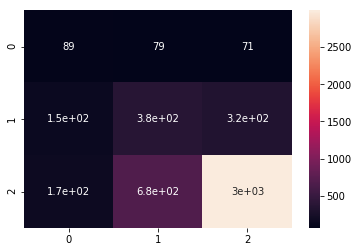

In [27]:
generate_classification_report(LINEAR_MODEL,
                               VALIDATION_DATAFRAME,
                               expand_onehot_encoding(
                                   FEATURES_VALIDATION_DATAFRAME.drop(['listing_id', 'label_interest_level'], axis=1),
                                   CATEGORICAL_FEATURES,
                               ),
                               FEATURES_VALIDATION_DATAFRAME['label_interest_level'],
                               [0, 1, 2])

In [28]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns(
        LINEAR_MODEL,
        FEATURES_TEST_DATAFRAME['listing_id'],
        expand_onehot_encoding(
            FEATURES_TRAIN_DATAFRAME.drop(['listing_id', 'label_interest_level'], axis=1),
            CATEGORICAL_FEATURES,
        ),
    ),
    'renthop_logistic_regression_submissions.csv'
)

/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, Deprecati

In [29]:
CATEGORICAL_FEATURES

{'building_id_category': 540,
 'manager_id_category': 718,
 'display_address_category': 581}

### 3.2) XGBoost

In [30]:
(XGBOOST_STATISTICS,
 XGBOOST_LABELS,
 XGBOOST_PREDICTIONS,
 XGBOOST_MODEL) = test_model_with_k_fold_cross_validation(
    basic_xgboost_pipeline(CATEGORICAL_FEATURES,
                           n_estimators=10000,
                           tree_method=('gpu_hist' if torch.cuda.is_available() else None)),
    expand_onehot_encoding(
        numerical_feature_engineering_on_dataframe(
            FEATURES_TRAIN_DATAFRAME.drop(['listing_id', 'label_interest_level'], axis=1),
            NUMERICAL_COLUMNS
        ),
        CATEGORICAL_FEATURES,
    ),
    TRAIN_LABELS,
    {
        "accuracy": prediction_accuracy,
        "log_loss": log_loss
    },
    n_splits=2
)

print('XGBoost', format_statistics(XGBOOST_STATISTICS))

/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, Deprecati

Fold 0 accuracy: 0.74, log_loss: 0.68
Fold 1 accuracy: 0.73, log_loss: 0.68
XGBoost accuracy: 0.73, log_loss: 0.68


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, Deprecati

Label was 0, classified as 0


,description,price,bedrooms,bathrooms,photos_count
2,5TH ST/ 2 AVE! RENOVATED 2 BEDROOM IN CHARMING...,3200,2,1.0,6
9,83RD/ AMSTERDAM! TRUE 2 BED IN NICE WELL KEPT ...,3000,2,1.0,6
71,"Well maintained elevator building, offers a th...",1450,0,1.0,7
79,Large studio located on the 2nd floor in Prime...,1795,0,1.0,4
81,These pictures are from a similarlisting.,2295,2,1.0,6


Label was 0, classified as 1


,description,price,bedrooms,bathrooms,photos_count
46,Gorgeous Renovated Studio apartment in Kew Gar...,1375,0,1.0,7
47,Simply amazing!!!! Spacious 3 bedroom apartmen...,1899,3,1.0,8
107,Lexington AVE on 88th ST ~ Just LISTED 2 BED !...,2600,2,1.0,5
159,LOW FEE!! NEW TO MARKET!!! HUGE 1 BED br. 1 b...,2175,1,1.0,4
188,Gramercy Park/Union Square! Huge 3 bedroom apa...,4553,3,1.0,5


Label was 0, classified as 2


,description,price,bedrooms,bathrooms,photos_count
69,Spacious studio apartment near Fulton Street M...,2495,0,1.0,5
140,This luxury studio has an open -space layout w...,2500,0,1.0,7
251,NEW!! Rare Large two bedroom in the east villa...,3300,2,1.0,5
409,"Welcome home to this luxury, bright loft-like ...",2395,0,1.0,3
428,"I HAVE AMAZING STUDIO AVAILABLE .BRAND NEW , J...",2500,0,1.0,2


Label was 1, classified as 0


,description,price,bedrooms,bathrooms,photos_count
48,Prewar Charm !! East 80s & 1st AVE ~ Gorgeous ...,1775,0,1.0,3
59,This 1 Bedroom Apartment is Located Just 5 BLO...,1800,1,1.0,7
99,"High Floor, Bright And Spacious Two Be...",2150,2,1.0,10
105,- Tree-lined block - Restaurants nearby - Quie...,1850,2,1.0,5
113,Building features: Elevator/Laundry/Fitness ro...,1950,2,2.0,5


Label was 1, classified as 1


,description,price,bedrooms,bathrooms,photos_count
23,Charming 1 Bedroom Apartment for Rent in Boeru...,2500,1,1.0,12
24,LISTING ID: 150804\rSunny apartment in a quiet...,2050,1,1.0,3
34,This bright 1 bedroom apartment is located jus...,2100,1,1.0,5
52,"AS YOU ENTER THIS ULTRA LUXURY BUILDING, YOU W...",2865,2,1.0,6
56,Impeccably located in an elevator building wit...,2400,1,1.0,7


Label was 1, classified as 2


,description,price,bedrooms,bathrooms,photos_count
17,Residential Prewar Building With Art Deco Flai...,2995,2,1.0,4
31,Prime Murray Hill Neighborhood! Located off ...,2350,0,1.0,2
43,PRIME Greenwich Village!\r\rMASSIVE 2BR!\r\rHi...,4350,2,1.0,4
45,"Move in to this great spacious studio, will no...",2550,0,1.0,3
58,This is a Gut Renovated 3 Bedroom w/ Washer & ...,5200,3,3.0,14


Label was 2, classified as 0


,description,price,bedrooms,bathrooms,photos_count
38,"Now available, absolutely stunning 1 bedroom 1...",401,1,1.0,7
155,***E 53rd/2nd!! GARDEN APARTMENT!! MASSIVE LOF...,2200,0,1.0,5
441,This spacious sun drenched flex 3 apartment is...,3200,3,1.0,4
451,~Midtown 6th Ave~Convertible 3 Bedrooms with F...,4650,3,2.0,5
705,Beautiful studio flex three bedroom in a stunn...,3000,3,1.0,6


Label was 2, classified as 1


,description,price,bedrooms,bathrooms,photos_count
3,85TH/ 3 AVE! UNIQUE 800 SQFT PENTHOUSE DUPLEX ...,2850,1,2.0,6
8,,2200,2,1.0,20
10,Alcove studio\r\rRenovated kitchen and bathroo...,2550,1,1.0,2
15,COME SEE THIS AMAZING DISPLAY OF PERFECTION! L...,3400,3,1.0,7
25,!!!!!!!! This will end your search!!!!!!!!!***...,2525,0,1.0,11


Label was 2, classified as 2


,description,price,bedrooms,bathrooms,photos_count
0,THE PRICE IS NET EFFECTIVE - One month Free on...,2900,1,1.0,4
1,Spacious and contemporary alcove studio with h...,4000,0,1.0,4
4,This HUGE STUDIO LOFT apartment HAS AN AMAZING...,3100,0,1.0,5
5,"Located on west 57th st , short walk from Colu...",4000,2,1.0,6
6,AMAZING TWO BEDROOM UNIT!HUGE LIVING AREA WITH...,5125,2,2.0,14


              precision    recall  f1-score   support

           0       0.38      0.49      0.43       301
           1       0.39      0.46      0.42       946
           2       0.88      0.82      0.85      3689

   micro avg       0.73      0.73      0.73      4936
   macro avg       0.55      0.59      0.57      4936
weighted avg       0.76      0.73      0.74      4936

Logistic loss 0.67566


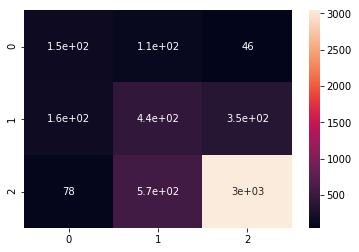

In [31]:
generate_classification_report(XGBOOST_MODEL,
                               VALIDATION_DATAFRAME,
                               expand_onehot_encoding(
                                   numerical_feature_engineering_on_dataframe(
                                       FEATURES_VALIDATION_DATAFRAME.drop(['listing_id', 'label_interest_level'], axis=1),
                                       NUMERICAL_COLUMNS
                                   ),
                                   CATEGORICAL_FEATURES,
                               ),
                               FEATURES_VALIDATION_DATAFRAME['label_interest_level'],
                               [0, 1, 2])

In [32]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns(
        XGBOOST_MODEL,
        FEATURES_TEST_DATAFRAME['listing_id'],
        expand_onehot_encoding(
            numerical_feature_engineering_on_dataframe(
                FEATURES_TEST_DATAFRAME.drop(['listing_id', 'label_interest_level'], axis=1),
                NUMERICAL_COLUMNS
            ),
            CATEGORICAL_FEATURES
        ) 
    ),
    'xgboost_submissions.csv'
)

/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, Deprecati

### 3.3) Neural Net (Text Classification) Approaches

Here we leverage the actual text in the "description" field to try and do the classification, both independently and on top of the tabular data using Neural Nets with PyTorch.

Before we do that, it will be convenient to split our
data into continuous and categorical sections (as the categorical
sections will be put through independent embeddings in each
model) and tensorify some of our data, so lets do that now.

Note that the continuous data needs to be scaled to have zero mean
and unit variance - this prevents saturation of activation units
in the upper classification layers.

In [30]:
((TRAIN_FEATURES_CONTINUOUS,
  TRAIN_FEATURES_CATEGORICAL),
 (VALIDATION_FEATURES_CONTINUOUS,
  VALIDATION_FEATURES_CATEGORICAL),
 (TEST_FEATURES_CONTINUOUS,
  TEST_FEATURES_CATEGORICAL)) = rescale_features_and_split_into_continuous_and_categorical(CATEGORICAL_FEATURES,
                                                                                           FEATURES_TRAIN_DATAFRAME,
                                                                                           FEATURES_VALIDATION_DATAFRAME,
                                                                                           FEATURES_TEST_DATAFRAME)

Now we convert the labels into tensors, but we only put the labels
on the GPU (not the rest of the data, we'd run out of memory). Skorch
will conveniently put each batch on the GPU for us, so we don't need to
worry about that.

In [31]:
TRAIN_LABELS_TENSOR = maybe_cuda(torch.tensor(TRAIN_LABELS.values).long())
VALIDATION_LABELS_TENSOR = maybe_cuda(torch.tensor(VALIDATION_LABELS.values).long())

In [32]:
TRAIN_FEATURES_CONTINUOUS_TENSOR = torch.tensor(TRAIN_FEATURES_CONTINUOUS).float()
TRAIN_FEATURES_CATEGORICAL_TENSOR = torch.tensor(TRAIN_FEATURES_CATEGORICAL).long()

In [33]:
VALIDATION_FEATURES_CONTINUOUS_TENSOR = torch.tensor(VALIDATION_FEATURES_CONTINUOUS).float()
VALIDATION_FEATURES_CATEGORICAL_TENSOR = torch.tensor(VALIDATION_FEATURES_CATEGORICAL).long()

In [34]:
TEST_FEATURES_CONTINUOUS_TENSOR = torch.tensor(TEST_FEATURES_CONTINUOUS).float()
TEST_FEATURES_CATEGORICAL_TENSOR = torch.tensor(TEST_FEATURES_CATEGORICAL).long()

#### 3.3.1) Simple RNN/LSTM

Before we start putting our data into the RNN, lets tokenize our descriptions. In order to do this we'll be using fastai's Tokenizer class. We can preview the result of tokenization below

In [38]:
pd.DataFrame(list(zip(*[
    list(TRAIN_DATAFRAME["description"][:10]),
    list(itertools.chain.from_iterable([
        [" ".join(s for s in sequence) for sequence in sequences]
        for sequences in tokenize_sequences(TRAIN_DATAFRAME["description"][:10])
    ]))
])), columns=["Original", "Tokenized"])

,Original,Tokenized
0,**AMAZING 3BD FLEX*** ROOFTOP DECK***! YOUR SE...,* * xxup amazing xxup 3bd xxup flex * * * xxup...
1,This unit was a gut renovation true studio. Ev...,xxmaj this unit was a gut renovation true stud...
2,"This spacious studio features high ceilings, l...",xxmaj this spacious studio features high ceili...
3,RENOVATED studio apartment with great SPACIOUS...,xxup renovated studio apartment with great xxu...
4,89TH/1ST LARGE STUDIO!! LUX ELV BLDG! BALCONY!...,xxup 89th / xxup 1st xxup large xxup studio ! ...
5,Stunning Three Bedroom Home Featuring: -Modern...,xxmaj stunning xxmaj three xxmaj bedroom xxmaj...
6,"Fully Furnished 2 bedroom, 1 Bathroom- Spacio...","xxmaj fully xxmaj furnished 2 bedroom , 1 xxma..."
7,Awesome 24 hour doorman building....shares OK!...,xxmaj awesome 24 hour doorman building xxrep 4...
8,SPACIOUS one bedroom in prime East Williamsbur...,xxup spacious one bedroom in prime xxmaj east ...
9,No Fee!Full Service.Elevator.Doorman.Close to ...,xxmaj no fee!full xxmaj service . xxmaj elevat...


Now we need to encode our tokens as **padded** sequences of integers such that we have a matrix of length [n $\times$ max_len].

To start our with, PyTorch takes one-hot encoded data as a single array of integers, where each integer specifies the index into some sparse vector where a $1$ will be set. Of course, if you have such sparse vectors, you can save a lot of time on the multiplication by just picking the right dimension and ignoring all the zero ones, which is exactly what happens internally.

The reason why we need padding is for computational efficiency reasons - we want to push a large batch of sentences on to the GPU for parallel computation all, but in order for this to work we need to pass the GPU a big square matrix. This means that the matrix will have at least as many columns as the maximum number of tokens in a sentence, where every other shorter sentence will be padded by a special "<PAD>" token. We also keep the length of every unpadded sentence in a separate vector - we'll see later that this is used by torch as an optimization to prevent the RNN from running over all the padding tokens within a batch.

In [39]:
((WORD_TO_ONE_HOT,
  ONE_HOT_TO_WORD),
 ((TRAIN_WORD_DESCRIPTION_SEQUENCES,
   TRAIN_WORD_SEQUENCES_LENGTHS),
  (VALIDATION_WORD_DESCRIPTION_SEQUENCES,
   VALIDATION_WORD_SEQUENCES_LENGTHS),
  (TEST_WORD_DESCRIPTION_SEQUENCES,
   TEST_WORD_SEQUENCES_LENGTHS))) = generate_description_sequences(
     token_dictionary_seq_encoder,
     TRAIN_DATAFRAME["description"],
     VALIDATION_DATAFRAME["description"],
     TEST_DATAFRAME["description"],
)

In [40]:
pd.DataFrame(list(zip(*[
    list(TRAIN_DATAFRAME["description"][:10]),
    [
        ", ".join(str(s) for s in sequence)
        for sequence in TRAIN_WORD_DESCRIPTION_SEQUENCES.numpy()[:10]
    ],
    TRAIN_WORD_SEQUENCES_LENGTHS.numpy()[:10]
])), columns=["Original", "Encoded", "Length"])

,Original,Encoded,Length
0,**AMAZING 3BD FLEX*** ROOFTOP DECK***! YOUR SE...,"93163, 91429, 50053, 85402, 14018, 93165, 8164...",879
1,This unit was a gut renovation true studio. Ev...,"13886, 66182, 13901, 93163, 33028, 51902, 1387...",810
2,"This spacious studio features high ceilings, l...","170, 170, 93165, 63839, 93165, 26618, 93165, 4...",727
3,RENOVATED studio apartment with great SPACIOUS...,"170, 170, 93165, 63839, 93165, 26618, 93165, 4...",727
4,89TH/1ST LARGE STUDIO!! LUX ELV BLDG! BALCONY!...,"126, 93163, 57650, 13871, 2128, 1840, 7227, 18...",725
5,Stunning Three Bedroom Home Featuring: -Modern...,"126, 93164, 10217, 179, 93165, 20013, 93165, 6...",723
6,"Fully Furnished 2 bedroom, 1 Bathroom- Spacio...","126, 93164, 10217, 179, 93165, 20013, 93165, 6...",719
7,Awesome 24 hour doorman building....shares OK!...,"93163, 36046, 93163, 84760, 52563, 14018, 9316...",706
8,SPACIOUS one bedroom in prime East Williamsbur...,"2520, 93165, 62119, 93165, 45945, 65233, 3800,...",700
9,No Fee!Full Service.Elevator.Doorman.Close to ...,"93163, 49585, 84605, 136, 13871, 175, 90, 9316...",699


Here we roll our own simple LSTM classifier using Skorch and PyTorch.

The `SimpleRNNPredictor` model just takes a batch of encoded word-encoded
sentences and runs them through a Bi-LSTM, then has a fully connected
layer sitting on top of the final "hidden" output of the LSTM (think
of the hidden state being passed through the LSTM along with each encoded input for the entire sentence all the way up to the sentence length). Then we just predict the class based on the final hidden state.

What Skorch does here is it implements the training loop, allows us
to add "hooks" (for instance, scoring on every epoch, a progress bar,
checkpointing so that we only keep our best model by validation loss,
cyclic learning rate scheduling and learning rate annealing (we reduce the learning rate if our validation loss is not going down)). It also wraps the model in an sklearn estimator-like API, so we can use it just like any other estimator.

Note that the NoToTensorInLossClassifier implements a few fixes on top
of NeuralNetClassifier - in particular `predict_proba` takes the exponent of the returned probabilities since we return log-softmax probabilities that get passed to `NLLLoss`.

In [41]:
SIMPLE_RNN_MODEL = NoToTensorInLossClassifier(
    SimpleRNNPredictor,
    module__encoder_dimension=100, # Number of encoder features
    module__hidden_dimension=50, # Number of hidden features
    module__dictionary_dimension=len(ONE_HOT_TO_WORD), # Dictionary dimension
    module__output_dimension=3,
    module__dropout=0.1,
    lr=1e-2,
    batch_size=256,
    optimizer=optim.Adam,
    max_epochs=10,
    module__layers=2,
    train_split=simple_train_test_split_without_shuffle_func(0.3),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=[
        EpochScoring(scoring='accuracy'),
        LRAnnealing(),
        LRScheduler(),
        ProgressBar(),
        CheckpointAndKeepBest(dirname='rnn_lang_checkpoint'),
        TrainEndCheckpoint(dirname='rnn_lang_checkpoint',
                           fn_prefix='rnn_train_end_')
    ]
)

In [42]:
SIMPLE_RNN_MODEL.fit((TRAIN_WORD_DESCRIPTION_SEQUENCES,
                      TRAIN_WORD_SEQUENCES_LENGTHS),
                     TRAIN_LABELS_TENSOR)

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.6229        0.8652       0.6229        0.9085     +  87.0196


      2      0.6783        0.8300       0.6783        0.9038     +  86.7877


      3      0.6842        0.8157       0.6842        0.8672     +  86.9980


      4      0.6787        0.8076       0.6787        0.8908        86.8562


      5      0.6837        0.8036       0.6837        0.8707        86.9361


      6      0.6741        0.7969       0.6741        0.8561     +  87.2589


      7      0.6566        0.7843       0.6566        0.8608        86.9161


      8      0.6688        0.7719       0.6688        0.8570        86.9988


      9      0.6719        0.7577       0.6719        0.8586        86.9946


     10      0.6716        0.7393       0.6716        0.8663        86.9280
Loading parameters from checkpoint 5


<class 'utils.language_models.simple_rnn.NoToTensorInLossClassifier'>[initialized](
  module_=SimpleRNNPredictor(
    (word_encoder): Embedding(94388, 100)
    (rnn): LSTM(100, 50, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
    (decoder): Linear(in_features=200, out_features=3, bias=True)
    (class_decoder1): Linear(in_features=200, out_features=128, bias=True)
    (class_decoder2): Linear(in_features=128, out_features=128, bias=True)
    (class_decoder3): Linear(in_features=128, out_features=3, bias=True)
  ),
)

Label was 0, classified as 0


,description,price,bedrooms,bathrooms,photos_count
360,2 Bedroom available on the first floor of a pr...,1950,2,1.0,5
2912,Spacious 3BR!! Elevator building- separate eat...,5395,3,1.0,9


Label was 0, classified as 1


,description,price,bedrooms,bathrooms,photos_count
571,*** 100% NO FEE***3 BEDROOM 2BATH CONV. FEATUR...,3900,3,2.0,6
798,This one bedroom Inwood apartment is located o...,1650,1,1.0,4
824,"** Exclusive - 97 Clinton St ** - Bright, Larg...",3595,3,1.0,10
1328,,2950,3,1.0,13
2573,,1100,2,2.0,0


Label was 0, classified as 2


,description,price,bedrooms,bathrooms,photos_count
2,5TH ST/ 2 AVE! RENOVATED 2 BEDROOM IN CHARMING...,3200,2,1.0,6
9,83RD/ AMSTERDAM! TRUE 2 BED IN NICE WELL KEPT ...,3000,2,1.0,6
46,Gorgeous Renovated Studio apartment in Kew Gar...,1375,0,1.0,7
47,Simply amazing!!!! Spacious 3 bedroom apartmen...,1899,3,1.0,8
69,Spacious studio apartment near Fulton Street M...,2495,0,1.0,5


Label was 1, classified as 0


,description,price,bedrooms,bathrooms,photos_count


Label was 1, classified as 1


,description,price,bedrooms,bathrooms,photos_count
23,Charming 1 Bedroom Apartment for Rent in Boeru...,2500,1,1.0,12
52,"AS YOU ENTER THIS ULTRA LUXURY BUILDING, YOU W...",2865,2,1.0,6
329,"Comfortable spacious renovated apartment, with...",1900,2,1.0,9
543,NESTLED IN THE HEART OF THE FINANCIAL DISTRICT...,2750,1,1.0,6
573,***ENORMOUS ENTRANCE REMEMBERING AN ENTRANCE O...,4700,2,2.0,7


Label was 1, classified as 2


,description,price,bedrooms,bathrooms,photos_count
17,Residential Prewar Building With Art Deco Flai...,2995,2,1.0,4
24,LISTING ID: 150804\rSunny apartment in a quiet...,2050,1,1.0,3
31,Prime Murray Hill Neighborhood! Located off ...,2350,0,1.0,2
34,This bright 1 bedroom apartment is located jus...,2100,1,1.0,5
43,PRIME Greenwich Village!\r\rMASSIVE 2BR!\r\rHi...,4350,2,1.0,4


Label was 2, classified as 0


,description,price,bedrooms,bathrooms,photos_count
2684,,3795,1,1.0,0


Label was 2, classified as 1


,description,price,bedrooms,bathrooms,photos_count
26,"Spacious, Abundance of Closets, Washer/Dryer i...",5195,1,1.0,14
98,**2Bd/1BTH/FLEX located in the Heart of it all...,3000,2,1.0,5
218,Building AmenitiesGarage ParkingGymLaundry in ...,5500,2,3.0,6
248,Apartment is newly renovated featuring: bleach...,5500,3,2.0,8
261,BEAUTIFUL CONVERTIBLE 2 BEDROOM / 1 BAFEATURIN...,2700,2,1.0,5


Label was 2, classified as 2


,description,price,bedrooms,bathrooms,photos_count
0,THE PRICE IS NET EFFECTIVE - One month Free on...,2900,1,1.0,4
1,Spacious and contemporary alcove studio with h...,4000,0,1.0,4
3,85TH/ 3 AVE! UNIQUE 800 SQFT PENTHOUSE DUPLEX ...,2850,1,2.0,6
4,This HUGE STUDIO LOFT apartment HAS AN AMAZING...,3100,0,1.0,5
5,"Located on west 57th st , short walk from Colu...",4000,2,1.0,6


              precision    recall  f1-score   support

           0       0.01      0.67      0.01         3
           1       0.03      0.23      0.05       127
           2       0.97      0.70      0.81      4806

   micro avg       0.69      0.69      0.69      4936
   macro avg       0.33      0.53      0.29      4936
weighted avg       0.95      0.69      0.79      4936

Logistic loss 0.83758


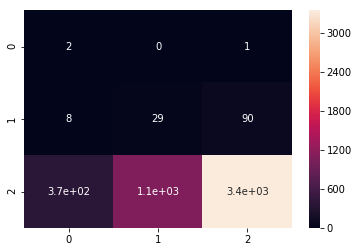

In [43]:
generate_classification_report(SIMPLE_RNN_MODEL,
                               VALIDATION_DATAFRAME,
                               (VALIDATION_WORD_DESCRIPTION_SEQUENCES,
                                VALIDATION_WORD_SEQUENCES_LENGTHS),
                               VALIDATION_LABELS.values,
                               [0, 1, 2])

In [44]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns(
        SIMPLE_RNN_MODEL,
        FEATURES_TEST_DATAFRAME['listing_id'],
        (TEST_WORD_DESCRIPTION_SEQUENCES,
         TEST_WORD_SEQUENCES_LENGTHS),
        
    ),
    'simple_rnn_model_submissions.csv'
)

In [45]:
SIMPLE_RNN_MODEL_WITH_TABULAR_DATA = NoToTensorInLossClassifier(
    SimpleRNNTabularDataPredictor,
    lr=0.01,
    batch_size=256,
    optimizer=optim.Adam,
    callbacks=[
        EpochScoring(scoring='accuracy'),
        LRAnnealing(),
        LRScheduler(),
        ProgressBar(),
        CheckpointAndKeepBest(dirname='rnn_tabular_checkpoint'),
        TrainEndCheckpoint(dirname='rnn_tabular_checkpoint',
                           fn_prefix='rnn_train_end_')
    ],
    max_epochs=10,
    module__layers=2,
    train_split=simple_train_test_split_without_shuffle_func(0.3),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    module__encoder_dimension=100, # Number of encoder features
    module__hidden_dimension=50, # Number of hidden features
    module__dictionary_dimension=len(ONE_HOT_TO_WORD), # Dictionary dimension
    module__continuous_features_dimension=TRAIN_FEATURES_CONTINUOUS.shape[1],
    module__categorical_feature_embedding_dimensions=[
        (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
    ],
    module__output_dimension=3,
    module__dropout=0.1
)

In [46]:
SIMPLE_RNN_MODEL_WITH_TABULAR_DATA.fit((TRAIN_WORD_DESCRIPTION_SEQUENCES,
                                        TRAIN_WORD_SEQUENCES_LENGTHS,
                                        TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                        TRAIN_FEATURES_CATEGORICAL_TENSOR),
                                       TRAIN_LABELS_TENSOR)

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.6961        0.8032       0.6961        0.6847     +  87.5549


      2      0.7081        0.6631       0.7081        0.6708     +  87.6228


      3      0.7112        0.6419       0.7112        0.6644     +  87.6264


      4      0.7070        0.6302       0.7070        0.6668        87.6277


      5      0.7018        0.6194       0.7018        0.6655        87.5124


      6      0.7019        0.6067       0.7019        0.6687        87.5750


      7      0.7032        0.5943       0.7032        0.6691        87.5323


      8      0.7026        0.5803       0.7026        0.6804        87.6530


      9      0.7026        0.5637       0.7026        0.6796        87.4699


     10      0.7012        0.5495       0.7012        0.6815        87.6119
Loading parameters from checkpoint 2


<class 'utils.language_models.simple_rnn.NoToTensorInLossClassifier'>[initialized](
  module_=SimpleRNNTabularDataPredictor(
    (word_encoder): Embedding(94388, 100)
    (emb_0): Embedding(540, 80)
    (emb_1): Embedding(718, 80)
    (emb_2): Embedding(581, 80)
    (rnn): LSTM(100, 50, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
    (class_decoder1): Linear(in_features=547, out_features=128, bias=True)
    (class_decoder2): Linear(in_features=128, out_features=128, bias=True)
    (class_decoder3): Linear(in_features=128, out_features=3, bias=True)
  ),
)

Label was 0, classified as 0


,description,price,bedrooms,bathrooms,photos_count


Label was 0, classified as 1


,description,price,bedrooms,bathrooms,photos_count
2,5TH ST/ 2 AVE! RENOVATED 2 BEDROOM IN CHARMING...,3200,2,1.0,6
9,83RD/ AMSTERDAM! TRUE 2 BED IN NICE WELL KEPT ...,3000,2,1.0,6
107,Lexington AVE on 88th ST ~ Just LISTED 2 BED !...,2600,2,1.0,5
186,ELEVATOR - LAUNDRY - SS APPLIANCES - RECESSED ...,2100,2,1.0,9
188,Gramercy Park/Union Square! Huge 3 bedroom apa...,4553,3,1.0,5


Label was 0, classified as 2


,description,price,bedrooms,bathrooms,photos_count
46,Gorgeous Renovated Studio apartment in Kew Gar...,1375,0,1.0,7
47,Simply amazing!!!! Spacious 3 bedroom apartmen...,1899,3,1.0,8
69,Spacious studio apartment near Fulton Street M...,2495,0,1.0,5
71,"Well maintained elevator building, offers a th...",1450,0,1.0,7
79,Large studio located on the 2nd floor in Prime...,1795,0,1.0,4


Label was 1, classified as 0


,description,price,bedrooms,bathrooms,photos_count


Label was 1, classified as 1


,description,price,bedrooms,bathrooms,photos_count
31,Prime Murray Hill Neighborhood! Located off ...,2350,0,1.0,2
48,Prewar Charm !! East 80s & 1st AVE ~ Gorgeous ...,1775,0,1.0,3
59,This 1 Bedroom Apartment is Located Just 5 BLO...,1800,1,1.0,7
73,"Building Features: Doorman & concierge, Bike R...",3100,2,1.0,9
74,Four bedroom (flex) apartment comes with 2 ful...,6195,4,2.0,5


Label was 1, classified as 2


,description,price,bedrooms,bathrooms,photos_count
17,Residential Prewar Building With Art Deco Flai...,2995,2,1.0,4
23,Charming 1 Bedroom Apartment for Rent in Boeru...,2500,1,1.0,12
24,LISTING ID: 150804\rSunny apartment in a quiet...,2050,1,1.0,3
34,This bright 1 bedroom apartment is located jus...,2100,1,1.0,5
43,PRIME Greenwich Village!\r\rMASSIVE 2BR!\r\rHi...,4350,2,1.0,4


Label was 2, classified as 0


,description,price,bedrooms,bathrooms,photos_count


Label was 2, classified as 1


,description,price,bedrooms,bathrooms,photos_count
10,Alcove studio\r\rRenovated kitchen and bathroo...,2550,1,1.0,2
19,ACTUAL APT. PHOTOS - Doorman - Elevator - Laun...,2500,0,1.0,6
30,***MASSIVE 1 BR GEM******PRIME UPPER EAST SIDE...,2325,1,1.0,4
76,NO Brokers fees!!! ONE Month Free!! Limited ti...,3050,2,1.0,4
111,"Beautiful, large one bedroom in a 24 hour door...",4400,1,1.0,9


Label was 2, classified as 2


,description,price,bedrooms,bathrooms,photos_count
0,THE PRICE IS NET EFFECTIVE - One month Free on...,2900,1,1.0,4
1,Spacious and contemporary alcove studio with h...,4000,0,1.0,4
3,85TH/ 3 AVE! UNIQUE 800 SQFT PENTHOUSE DUPLEX ...,2850,1,2.0,6
4,This HUGE STUDIO LOFT apartment HAS AN AMAZING...,3100,0,1.0,5
5,"Located on west 57th st , short walk from Colu...",4000,2,1.0,6


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.23      0.45      0.31       573
           2       0.94      0.74      0.83      4363

   micro avg       0.71      0.71      0.71      4936
   macro avg       0.39      0.40      0.38      4936
weighted avg       0.86      0.71      0.77      4936

Logistic loss 0.66568


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


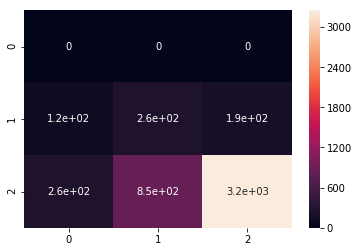

In [47]:
generate_classification_report(SIMPLE_RNN_MODEL_WITH_TABULAR_DATA,
                               VALIDATION_DATAFRAME,
                               (VALIDATION_WORD_DESCRIPTION_SEQUENCES,
                                VALIDATION_WORD_SEQUENCES_LENGTHS,
                                VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                               VALIDATION_LABELS.values,
                               [0, 1, 2])

In [48]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns(
        SIMPLE_RNN_MODEL_WITH_TABULAR_DATA,
        FEATURES_TEST_DATAFRAME['listing_id'],
        (TEST_WORD_DESCRIPTION_SEQUENCES,
         TEST_WORD_SEQUENCES_LENGTHS,
         TEST_FEATURES_CONTINUOUS_TENSOR,
         TEST_FEATURES_CATEGORICAL_TENSOR),
        
    ),
    'simple_rnn_model_tabular_data_submissions.csv'
)

### 3.3.2) FastText

A key concept here is that we compute the bigrams of a sentence and then apply them to the end of the sentence.

Then we just put the whole thing through linear layers after average pooling, the average pooling takes into account the big-grams.

In [49]:
(TRAIN_DATAFRAME_TOKEN_SEQUENCES,
 VALIDATION_DATAFRAME_TOKEN_SEQUENCES,
 TEST_DATAFRAME_TOKEN_SEQUENCES) = tokenize_sequences(
    list(TRAIN_DATAFRAME['clean_description']),
    list(VALIDATION_DATAFRAME['clean_description']),
    list(TEST_DATAFRAME['clean_description'])
)

(TRAIN_DATAFRAME_TOKEN_SEQUENCES_WITH_BIGRAMS,
 VALIDATION_DATAFRAME_TOKEN_SEQUENCES_WITH_BIGRAMS,
 TEST_DATAFRAME_TOKEN_SEQUENCES_WITH_BIGRAMS) = postprocess_sequences(
    TRAIN_DATAFRAME_TOKEN_SEQUENCES,
    VALIDATION_DATAFRAME_TOKEN_SEQUENCES,
    TEST_DATAFRAME_TOKEN_SEQUENCES,
    postprocessing=generate_bigrams
)

In [50]:
TEXT = torchtext_create_text_vocab(TRAIN_DATAFRAME_TOKEN_SEQUENCES,
                                   VALIDATION_DATAFRAME_TOKEN_SEQUENCES,
                                   TEST_DATAFRAME_TOKEN_SEQUENCES,
                                   vectors='glove.6B.100d')

01/20/2019 23:45:08 - INFO - torchtext.vocab -   Loading vectors from .vector_cache/glove.6B.100d.txt.pt


In [51]:
(TRAIN_DESCRIPTIONS_WITH_BIGRAMS,
 VALIDATION_DESCRIPTIONS_WITH_BIGRAMS,
 TEST_DESCRIPTIONS_WITH_BIGRAMS) = torchtext_process_texts(
    TRAIN_DATAFRAME_TOKEN_SEQUENCES,
    VALIDATION_DATAFRAME_TOKEN_SEQUENCES,
    TEST_DATAFRAME_TOKEN_SEQUENCES,
    text=TEXT
)

In [52]:
EMBEDDING_DIM = 100
FASTTEXT_MODEL = NoToTensorInLossClassifier(
    FastText,
    lr=0.001,
    batch_size=256,
    optimizer=optim.Adam,
    callbacks=[
        EpochScoring(scoring='accuracy'),
        LRAnnealing(),
        LRScheduler(),
        ProgressBar(),
        CheckpointAndKeepBest(dirname='fasttext_checkpoint'),
        TrainEndCheckpoint(dirname='fasttext_tabular_checkpoint',
                           fn_prefix='fasttext_train_end_')
    ],
    max_epochs=15,
    train_split=shuffled_train_test_split_by_indices(0.3),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    module__encoder_dimension=EMBEDDING_DIM, # Number of encoder features
    module__dictionary_dimension=len(TEXT.vocab.itos), # Dictionary dimension
    module__output_dimension=3,
    module__dropout=0.8,
    module__pretrained=TEXT.vocab.vectors
)

In [53]:
FASTTEXT_MODEL.fit(TRAIN_DESCRIPTIONS_WITH_BIGRAMS,
                   TRAIN_LABELS_TENSOR)

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.6949        0.7956       0.6949        0.7780     +  30.9680


      2      0.6949        0.7402       0.6949        0.7536     +  31.0583


      3      0.6962        0.6919       0.6962        0.7452     +  31.4546


      4      0.6709        0.6481       0.6709        0.7750        31.0182


      5      0.7024        0.6040       0.7024        0.8007        30.9874


      6      0.6903        0.5615       0.6903        0.7931        31.0842


      7      0.6717        0.5126       0.6717        0.8187        30.9579


      8      0.6974        0.4788       0.6974        0.8304        30.9650


      9      0.6916        0.4528       0.6916        0.8143        31.4024


     10      0.6954        0.4388       0.6954        0.8194        30.9510


     11      0.6983        0.4342       0.6983        0.8156        30.9490


     12      0.6555        0.5329       0.6555        0.8645        30.9532


     13      0.6101        0.4990       0.6101        0.9501        30.9581


     14      0.6858        0.4852       0.6858        0.8691        30.9651


     15      0.6690        0.4506       0.6690        0.9216        30.9556
Loading parameters from checkpoint 2


<class 'utils.language_models.simple_rnn.NoToTensorInLossClassifier'>[initialized](
  module_=FastText(
    (embedding): Embedding(504022, 100)
    (fc): Linear(in_features=100, out_features=3, bias=True)
  ),
)

Label was 0, classified as 0


,description,price,bedrooms,bathrooms,photos_count
2,5TH ST/ 2 AVE! RENOVATED 2 BEDROOM IN CHARMING...,3200,2,1.0,6
46,Gorgeous Renovated Studio apartment in Kew Gar...,1375,0,1.0,7
107,Lexington AVE on 88th ST ~ Just LISTED 2 BED !...,2600,2,1.0,5
139,The Apartment:<br />This is a beautifu...,1800,2,1.0,7
247,Live in Brooklyn Heights Historic District on ...,2550,2,1.0,5


Label was 0, classified as 1


,description,price,bedrooms,bathrooms,photos_count
9,83RD/ AMSTERDAM! TRUE 2 BED IN NICE WELL KEPT ...,3000,2,1.0,6
69,Spacious studio apartment near Fulton Street M...,2495,0,1.0,5
71,"Well maintained elevator building, offers a th...",1450,0,1.0,7
79,Large studio located on the 2nd floor in Prime...,1795,0,1.0,4
140,This luxury studio has an open -space layout w...,2500,0,1.0,7


Label was 0, classified as 2


,description,price,bedrooms,bathrooms,photos_count
47,Simply amazing!!!! Spacious 3 bedroom apartmen...,1899,3,1.0,8
81,These pictures are from a similarlisting.,2295,2,1.0,6
186,ELEVATOR - LAUNDRY - SS APPLIANCES - RECESSED ...,2100,2,1.0,9
188,Gramercy Park/Union Square! Huge 3 bedroom apa...,4553,3,1.0,5
212,RIVERDALE 1 BEDROOM .238 ST AREA. WALK TO 1 TR...,1450,1,1.0,3


Label was 1, classified as 0


,description,price,bedrooms,bathrooms,photos_count
48,Prewar Charm !! East 80s & 1st AVE ~ Gorgeous ...,1775,0,1.0,3
264,TRUE 2 BEDROOM W/ STAINLESS STEEL APPLIANCES -...,2800,2,1.0,5
312,The apartment is located in the desired Upper ...,2100,2,1.0,6
317,"Currently under renovation, this two b...",1550,2,1.0,1
321,"This apartment, building and neighborhood have...",2800,0,1.0,3


Label was 1, classified as 1


,description,price,bedrooms,bathrooms,photos_count
24,LISTING ID: 150804\rSunny apartment in a quiet...,2050,1,1.0,3
74,Four bedroom (flex) apartment comes with 2 ful...,6195,4,2.0,5
99,"High Floor, Bright And Spacious Two Be...",2150,2,1.0,10
123,89TH/ 2 AVE! DUPLEX 1 BEDROOM 750 SQF W/ 1.5...,2700,1,2.0,8
128,NO FEE !! STUNNING BUILDING LOCATED IN PRIME L...,4900,3,2.0,8


Label was 1, classified as 2


,description,price,bedrooms,bathrooms,photos_count
17,Residential Prewar Building With Art Deco Flai...,2995,2,1.0,4
23,Charming 1 Bedroom Apartment for Rent in Boeru...,2500,1,1.0,12
31,Prime Murray Hill Neighborhood! Located off ...,2350,0,1.0,2
34,This bright 1 bedroom apartment is located jus...,2100,1,1.0,5
43,PRIME Greenwich Village!\r\rMASSIVE 2BR!\r\rHi...,4350,2,1.0,4


Label was 2, classified as 0


,description,price,bedrooms,bathrooms,photos_count
131,Beautiful JR4 in Prime Riverdale Location. Us...,2150,2,1.0,3
175,One of a kind 2 flex bedroom in the heart of C...,3200,2,1.5,5
283,This stunning recently renovated one bedroom a...,1940,1,1.0,8
290,AMAZING RENOVATED 2BR APT WITH ALL NEW KITCHEN...,3400,2,1.0,5
408,NO FEE/FLEX1BED/BROADWAY/24DOORMAN/POOL/GYM<br...,3650,1,1.0,3


Label was 2, classified as 1


,description,price,bedrooms,bathrooms,photos_count
3,85TH/ 3 AVE! UNIQUE 800 SQFT PENTHOUSE DUPLEX ...,2850,1,2.0,6
70,Located in prime KIPS BAY / MURRAY HILL. 24 h...,2999,1,1.0,8
76,NO Brokers fees!!! ONE Month Free!! Limited ti...,3050,2,1.0,4
84,On the 26th floor of this luxury building in t...,2871,2,1.0,5
98,**2Bd/1BTH/FLEX located in the Heart of it all...,3000,2,1.0,5


Label was 2, classified as 2


,description,price,bedrooms,bathrooms,photos_count
0,THE PRICE IS NET EFFECTIVE - One month Free on...,2900,1,1.0,4
1,Spacious and contemporary alcove studio with h...,4000,0,1.0,4
4,This HUGE STUDIO LOFT apartment HAS AN AMAZING...,3100,0,1.0,5
5,"Located on west 57th st , short walk from Colu...",4000,2,1.0,6
6,AMAZING TWO BEDROOM UNIT!HUGE LIVING AREA WITH...,5125,2,2.0,14


              precision    recall  f1-score   support

           0       0.12      0.26      0.17       174
           1       0.24      0.42      0.30       631
           2       0.91      0.76      0.83      4131

   micro avg       0.70      0.70      0.70      4936
   macro avg       0.42      0.48      0.43      4936
weighted avg       0.80      0.70      0.74      4936

Logistic loss 0.75024


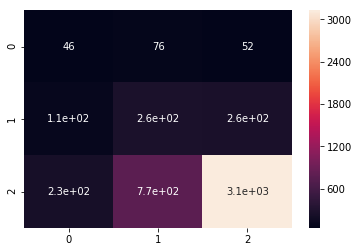

In [54]:
generate_classification_report(FASTTEXT_MODEL,
                               VALIDATION_DATAFRAME,
                               VALIDATION_DESCRIPTIONS_WITH_BIGRAMS,
                               VALIDATION_LABELS.values,
                               [0, 1, 2])

In [55]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns(
        FASTTEXT_MODEL,
        FEATURES_TEST_DATAFRAME['listing_id'],
        TEST_DESCRIPTIONS_WITH_BIGRAMS,
        
    ),
    'fasttext_model_submissions.csv'
)

In [56]:
FASTTEXT_WITH_TABULAR_MODEL = NoToTensorInLossClassifier(
    FastTextWithTabularData,
    lr=0.001,
    batch_size=256,
    optimizer=optim.Adam,
    callbacks=[
        EpochScoring(scoring='accuracy'),
        LRAnnealing(),
        LRScheduler(),
        ProgressBar(),
        CheckpointAndKeepBest(dirname='fasttext_tabular_checkpoint'),
        TrainEndCheckpoint(dirname='fasttext_tabular_checkpoint',
                           fn_prefix='fasttext_tabular_train_end_')
    ],
    max_epochs=20,
    train_split=shuffled_train_test_split_by_indices(0.3),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    module__encoder_dimension=EMBEDDING_DIM, # Number of encoder features
    module__dictionary_dimension=len(TEXT.vocab.itos), # Dictionary dimension
    module__output_dimension=3,
    module__dropout=0.8,
    module__pretrained=TEXT.vocab.vectors,
    module__continuous_features_dimension=TRAIN_FEATURES_CONTINUOUS.shape[1],
    module__categorical_feature_embedding_dimensions=[
        (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
    ],
)

In [57]:
FASTTEXT_WITH_TABULAR_MODEL.fit((TRAIN_DESCRIPTIONS_WITH_BIGRAMS,
                                 TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                 TRAIN_FEATURES_CATEGORICAL_TENSOR),
                                TRAIN_LABELS_TENSOR)

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.6630        1.0991       0.6630        1.0558     +  31.5073


      2      0.6217        1.0958       0.6217        1.5399        31.5160


      3      0.6349        1.0583       0.6349        1.5816        31.9257


      4      0.6583        0.9008       0.6583        1.3953        31.6990


      5      0.6733        0.7833       0.6733        1.5682        32.0831


      6      0.6708        0.7400       0.6708        1.3864        31.5090


      7      0.6736        0.6383       0.6736        1.0979        32.1366


      8      0.6788        0.5315       0.6788        0.9897     +  31.5204


      9      0.6974        0.4866       0.6974        0.8929     +  31.5725


     10      0.7098        0.4861       0.7098        0.7870     +  31.9735


     11      0.7059        0.4474       0.7059        0.7880        31.7501


     12      0.6429        0.8770       0.6429        1.4427        32.1693


     13      0.6048        0.9844       0.6048        2.2852        31.4916


     14      0.6675        1.0616       0.6675        2.3452        31.9651


     15      0.6565        1.0596       0.6565        2.5716        31.4936


     16      0.6419        0.9804       0.6419        2.4688        31.9562


     17      0.6449        0.7932       0.6449        2.4790        31.4706


     18      0.6609        0.7370       0.6609        2.5919        31.9657


     19      0.6654        0.7853       0.6654        3.0237        31.5126


     20      0.6629        0.8154       0.6629        2.7814        31.4943
Loading parameters from checkpoint 9


<class 'utils.language_models.simple_rnn.NoToTensorInLossClassifier'>[initialized](
  module_=FastTextWithTabularData(
    (embedding): Embedding(504022, 100)
    (fc): Linear(in_features=447, out_features=3, bias=True)
    (emb_0): Embedding(540, 80)
    (emb_1): Embedding(718, 80)
    (emb_2): Embedding(581, 80)
  ),
)

Label was 0, classified as 0


,description,price,bedrooms,bathrooms,photos_count
2,5TH ST/ 2 AVE! RENOVATED 2 BEDROOM IN CHARMING...,3200,2,1.0,6
139,The Apartment:<br />This is a beautifu...,1800,2,1.0,7
247,Live in Brooklyn Heights Historic District on ...,2550,2,1.0,5
332,Check Out This Lovely Studio Apartment...,1400,0,1.0,3
360,2 Bedroom available on the first floor of a pr...,1950,2,1.0,5


Label was 0, classified as 1


,description,price,bedrooms,bathrooms,photos_count
9,83RD/ AMSTERDAM! TRUE 2 BED IN NICE WELL KEPT ...,3000,2,1.0,6
46,Gorgeous Renovated Studio apartment in Kew Gar...,1375,0,1.0,7
47,Simply amazing!!!! Spacious 3 bedroom apartmen...,1899,3,1.0,8
69,Spacious studio apartment near Fulton Street M...,2495,0,1.0,5
71,"Well maintained elevator building, offers a th...",1450,0,1.0,7


Label was 0, classified as 2


,description,price,bedrooms,bathrooms,photos_count
188,Gramercy Park/Union Square! Huge 3 bedroom apa...,4553,3,1.0,5
270,Super spacious 4 bedroom apartment located in ...,3900,4,2.0,7
279,"IN THE HEART OF MIDTOWN EAST, THIS LUXURY BUIL...",6000,4,2.0,8
571,*** 100% NO FEE***3 BEDROOM 2BATH CONV. FEATUR...,3900,3,2.0,6
691,LUXURIOUS apartments with SPACIOUS rooms and a...,4690,4,2.0,5


Label was 1, classified as 0


,description,price,bedrooms,bathrooms,photos_count
24,LISTING ID: 150804\rSunny apartment in a quiet...,2050,1,1.0,3
31,Prime Murray Hill Neighborhood! Located off ...,2350,0,1.0,2
48,Prewar Charm !! East 80s & 1st AVE ~ Gorgeous ...,1775,0,1.0,3
59,This 1 Bedroom Apartment is Located Just 5 BLO...,1800,1,1.0,7
113,Building features: Elevator/Laundry/Fitness ro...,1950,2,2.0,5


Label was 1, classified as 1


,description,price,bedrooms,bathrooms,photos_count
17,Residential Prewar Building With Art Deco Flai...,2995,2,1.0,4
23,Charming 1 Bedroom Apartment for Rent in Boeru...,2500,1,1.0,12
34,This bright 1 bedroom apartment is located jus...,2100,1,1.0,5
45,"Move in to this great spacious studio, will no...",2550,0,1.0,3
52,"AS YOU ENTER THIS ULTRA LUXURY BUILDING, YOU W...",2865,2,1.0,6


Label was 1, classified as 2


,description,price,bedrooms,bathrooms,photos_count
43,PRIME Greenwich Village!\r\rMASSIVE 2BR!\r\rHi...,4350,2,1.0,4
58,This is a Gut Renovated 3 Bedroom w/ Washer & ...,5200,3,3.0,14
74,Four bedroom (flex) apartment comes with 2 ful...,6195,4,2.0,5
77,THIS IS THE ONE THAT WILL END YOUR SEARCH!!! ...,2150,1,1.0,7
122,**NO BROKER FEE FOR IMMEDIATE MOVE IN****LANDL...,3680,2,1.0,4


Label was 2, classified as 0


,description,price,bedrooms,bathrooms,photos_count
7,Stunning one bedroom apartment in Upper West S...,2595,1,1.0,3
11,"For the best apartment match up, kindly email ...",2775,1,1.0,5
32,Bright Renovated Studio Lot of Light Renovated...,2000,0,1.0,3
116,NO FEE! The advertised rent is the average or ...,2890,3,1.0,1
131,Beautiful JR4 in Prime Riverdale Location. Us...,2150,2,1.0,3


Label was 2, classified as 1


,description,price,bedrooms,bathrooms,photos_count
0,THE PRICE IS NET EFFECTIVE - One month Free on...,2900,1,1.0,4
3,85TH/ 3 AVE! UNIQUE 800 SQFT PENTHOUSE DUPLEX ...,2850,1,2.0,6
4,This HUGE STUDIO LOFT apartment HAS AN AMAZING...,3100,0,1.0,5
8,,2200,2,1.0,20
10,Alcove studio\r\rRenovated kitchen and bathroo...,2550,1,1.0,2


Label was 2, classified as 2


,description,price,bedrooms,bathrooms,photos_count
1,Spacious and contemporary alcove studio with h...,4000,0,1.0,4
5,"Located on west 57th st , short walk from Colu...",4000,2,1.0,6
6,AMAZING TWO BEDROOM UNIT!HUGE LIVING AREA WITH...,5125,2,2.0,14
13,COME SEE YOUR FUTURE HOME!!* NO BROKER FEE *BE...,6500,3,1.0,8
16,Rent listed is net effective after the first m...,4675,3,2.0,6


              precision    recall  f1-score   support

           0       0.30      0.27      0.29       428
           1       0.61      0.28      0.38      2421
           2       0.50      0.83      0.62      2087

   micro avg       0.51      0.51      0.51      4936
   macro avg       0.47      0.46      0.43      4936
weighted avg       0.54      0.51      0.48      4936

Logistic loss 3.42791


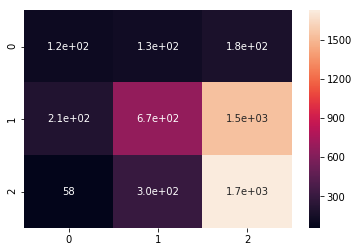

In [58]:
generate_classification_report(FASTTEXT_WITH_TABULAR_MODEL,
                               VALIDATION_DATAFRAME,
                               (VALIDATION_DESCRIPTIONS_WITH_BIGRAMS,
                                VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                               VALIDATION_LABELS.values,
                               [0, 1, 2])

In [59]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns(
        FASTTEXT_WITH_TABULAR_MODEL,
        FEATURES_TEST_DATAFRAME['listing_id'],
        (TEST_DESCRIPTIONS_WITH_BIGRAMS,
         TEST_FEATURES_CONTINUOUS_TENSOR,
         TEST_FEATURES_CATEGORICAL_TENSOR),
        
    ),
    'fasttext_tabular_model_submissions.csv'
)

### 3.3.3) TextCNN
Here we use a convolutional neural network on the text.

We kind of have to think of text like an "image". The horizontal
dimension is just each sentence (of variable length, but they all have
padding at the end). Then on the vertical axis, we have the word vectors
and we move our window across. Idea here is that similar to images, the
order between words and between word vector components probably matters,
so we take into account conceptual space and sentence space in the text
image domain.

In [60]:
# We don't want bigrams, so process agian without them.
TRAIN_DESCRIPTIONS_NO_BIGRAMS = TEXT.process(TRAIN_DATAFRAME_TOKEN_SEQUENCES).transpose(0, 1)
VALIDATION_DESCRIPTIONS_NO_BIGRAMS = TEXT.process(VALIDATION_DATAFRAME_TOKEN_SEQUENCES).transpose(0, 1)
TEST_DESCRIPTIONS_NO_BIGRAMS = TEXT.process(TEST_DATAFRAME_TOKEN_SEQUENCES).transpose(0, 1)

In [62]:
TEXTCNN_MODEL = NoToTensorInLossClassifier(
    TextCNN,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    callbacks=[
        EpochScoring(scoring='accuracy'),
        LRAnnealing(),
        LRScheduler(),
        ProgressBar(),
        CheckpointAndKeepBest(dirname='textcnn_checkpoint'),
        TrainEndCheckpoint(dirname='textcnn_tabular_checkpoint',
                           fn_prefix='textcnn_train_end_')
    ],
    max_epochs=20,
    train_split=shuffled_train_test_split_by_indices(0.3),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    module__encoder_dimension=EMBEDDING_DIM, # Number of encoder features
    module__dictionary_dimension=len(TEXT.vocab.itos), # Dictionary dimension
    module__output_dimension=3,
    module__n_filters=100,
    module__filter_sizes=(3, 4, 5),
    module__dropout=0.8,
    module__pretrained=TEXT.vocab.vectors
)

In [63]:
TEXTCNN_MODEL.fit(TRAIN_DESCRIPTIONS_NO_BIGRAMS,
                  TRAIN_LABELS_TENSOR)

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.6161       38.6755       0.6161       19.5851     +  54.1213


      2      0.6180       64.2776       0.6180       20.8149        54.1751


      3      0.6469       66.4635       0.6469       33.7897        54.1655


      4      0.6641       54.0866       0.6641       26.3199        54.0409


      5      0.6860       29.9768       0.6860       25.3552        54.1885


      6      0.6845       15.4055       0.6845       16.1615     +  54.2521


      7      0.6865        8.7358       0.6865       11.2860     +  54.3778


      8      0.6922        4.5391       0.6922       11.5789        54.1752


      9      0.6946        3.0808       0.6946       11.1792     +  54.2536


     10      0.6952        2.4607       0.6952       11.0131     +  54.0663


     11      0.6952        2.1135       0.6952       11.0121     +  54.1172


     12      0.6522       42.3978       0.6522      159.2392        54.1188


     13      0.6600      138.1062       0.6600      174.0651        54.0019


     14      0.6613      152.3733       0.6613      184.1898        54.0557


     15      0.6639      105.4700       0.6639      184.5354        53.9705


     16      0.6734       88.2806       0.6734      196.1663        54.0635


     17      0.6832       62.2258       0.6832      208.7286        53.9916


     18      0.6791       53.3989       0.6791      166.7184        53.9509


     19      0.6881       29.8502       0.6881      247.7513        54.2006


     20      0.6893       34.7543       0.6893      256.4452        54.1511
Loading parameters from checkpoint 10


<class 'utils.language_models.simple_rnn.NoToTensorInLossClassifier'>[initialized](
  module_=TextCNN(
    (embedding): Embedding(504022, 100)
    (conv_0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (conv_1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (conv_2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
    (fc): Linear(in_features=300, out_features=3, bias=True)
    (dropout): Dropout(p=0.8)
  ),
)

Label was 0, classified as 0


,description,price,bedrooms,bathrooms,photos_count
1033,Massive FLEX 4 extra large bedrooms. This brea...,6000,4,2.0,5


Label was 0, classified as 1


,description,price,bedrooms,bathrooms,photos_count
270,Super spacious 4 bedroom apartment located in ...,3900,4,2.0,7
402,Super spacious 2 bedroom apartment located in ...,2450,2,1.0,7
946,Beautiful two bedroom with empire state view l...,3300,2,1.0,10
1517,In the heart of Brooklyn is a collection of in...,1195,0,1.0,5
1806,Loft style living with this amazing flex 1 uni...,2425,1,1.0,4


Label was 0, classified as 2


,description,price,bedrooms,bathrooms,photos_count
2,5TH ST/ 2 AVE! RENOVATED 2 BEDROOM IN CHARMING...,3200,2,1.0,6
9,83RD/ AMSTERDAM! TRUE 2 BED IN NICE WELL KEPT ...,3000,2,1.0,6
46,Gorgeous Renovated Studio apartment in Kew Gar...,1375,0,1.0,7
47,Simply amazing!!!! Spacious 3 bedroom apartmen...,1899,3,1.0,8
69,Spacious studio apartment near Fulton Street M...,2495,0,1.0,5


Label was 1, classified as 0


,description,price,bedrooms,bathrooms,photos_count
3896,Apartment FeaturesDark oak flooring throughout...,3200,2,1.0,14


Label was 1, classified as 1


,description,price,bedrooms,bathrooms,photos_count
214,Amazing concessions - ONE MONTH FREE AND NO BR...,4075,2,2.0,6
238,Huge studio with alcove (separate sleeping are...,3176,1,1.0,6
264,TRUE 2 BEDROOM W/ STAINLESS STEEL APPLIANCES -...,2800,2,1.0,5
304,Studio w/ MASSIVE Private Outdoor Patio - in d...,2895,1,1.0,5
321,"This apartment, building and neighborhood have...",2800,0,1.0,3


Label was 1, classified as 2


,description,price,bedrooms,bathrooms,photos_count
17,Residential Prewar Building With Art Deco Flai...,2995,2,1.0,4
23,Charming 1 Bedroom Apartment for Rent in Boeru...,2500,1,1.0,12
24,LISTING ID: 150804\rSunny apartment in a quiet...,2050,1,1.0,3
31,Prime Murray Hill Neighborhood! Located off ...,2350,0,1.0,2
34,This bright 1 bedroom apartment is located jus...,2100,1,1.0,5


Label was 2, classified as 0


,description,price,bedrooms,bathrooms,photos_count
1269,Apartment FeaturesDark oak flooring throughout...,2400,1,1.0,14
2188,New Renovation! Northern Exposure The ideal ad...,4250,0,1.0,3
4795,This newly renovated large corner Junior four ...,4200,2,1.0,5


Label was 2, classified as 1


,description,price,bedrooms,bathrooms,photos_count
84,On the 26th floor of this luxury building in t...,2871,2,1.0,5
138,NO FEE ___W37__ over 1000 sq.ft__DINING AREA__...,4950,3,2.0,7
166,A handsome arched stone tunnel leads you to th...,2325,1,1.0,4
607,A studio in a luxury pet friendly doorman buil...,2800,0,1.0,7
671,*****AVAILABLE NOW***MUST SEE***PRIME LOCATION...,3590,1,1.0,6


Label was 2, classified as 2


,description,price,bedrooms,bathrooms,photos_count
0,THE PRICE IS NET EFFECTIVE - One month Free on...,2900,1,1.0,4
1,Spacious and contemporary alcove studio with h...,4000,0,1.0,4
3,85TH/ 3 AVE! UNIQUE 800 SQFT PENTHOUSE DUPLEX ...,2850,1,2.0,6
4,This HUGE STUDIO LOFT apartment HAS AN AMAZING...,3100,0,1.0,5
5,"Located on west 57th st , short walk from Colu...",4000,2,1.0,6


              precision    recall  f1-score   support

           0       0.00      0.20      0.01         5
           1       0.04      0.41      0.08       117
           2       0.98      0.70      0.82      4814

   micro avg       0.70      0.70      0.70      4936
   macro avg       0.34      0.44      0.30      4936
weighted avg       0.96      0.70      0.80      4936

Logistic loss 2.16094


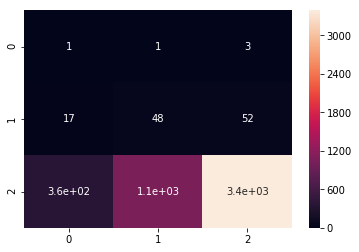

In [64]:
generate_classification_report(TEXTCNN_MODEL,
                               VALIDATION_DATAFRAME,
                               VALIDATION_DESCRIPTIONS_NO_BIGRAMS,
                               VALIDATION_LABELS.values,
                               [0, 1, 2])

In [65]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns(
        TEXTCNN_MODEL,
        FEATURES_TEST_DATAFRAME['listing_id'],
        TEST_DESCRIPTIONS_NO_BIGRAMS,
        
    ),
    'textcnn_model_submissions.csv'
)

In [66]:
TEXTCNN_WITH_TABULAR_MODEL = NoToTensorInLossClassifier(
    TextCNNWithTabularData,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    callbacks=[
        EpochScoring(scoring='accuracy'),
        LRAnnealing(),
        LRScheduler(),
        ProgressBar(),
        CheckpointAndKeepBest(dirname='textcnn_tabular_checkpoint'),
        TrainEndCheckpoint(dirname='textcnn_tabular_checkpoint',
                           fn_prefix='textcnn_tabular_train_end_')
    ],
    max_epochs=20,
    train_split=shuffled_train_test_split_by_indices(0.3),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    module__encoder_dimension=EMBEDDING_DIM, # Number of encoder features
    module__dictionary_dimension=len(TEXT.vocab.itos), # Dictionary dimension
    module__output_dimension=3,
    module__n_filters=100,
    module__filter_sizes=(3, 4, 5),
    module__dropout=0.5,
    module__continuous_features_dimension=TRAIN_FEATURES_CONTINUOUS.shape[1],
    module__categorical_feature_embedding_dimensions=[
        (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
    ],
    module__pretrained=TEXT.vocab.vectors
)

In [68]:
TEXTCNN_WITH_TABULAR_MODEL.fit((TRAIN_DESCRIPTIONS_NO_BIGRAMS,
                                TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                TRAIN_FEATURES_CATEGORICAL_TENSOR),
                               TRAIN_LABELS_TENSOR)

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.5441       24.4650       0.5441       44.5462     +  54.6271


      2      0.6614       38.6762       0.6614       39.0928     +  54.6661


      3      0.6396       50.7718       0.6396       36.6304     +  54.5844


      4      0.6097       41.2076       0.6097       49.4209        54.5967


      5      0.6247       26.6738       0.6247       36.0051     +  54.5838


      6      0.6434       16.3077       0.6434       47.4573        54.5988


      7      0.6453        8.4700       0.6453       41.1567        54.5809


      8      0.6554        6.0934       0.6554       26.9373     +  54.5499


      9      0.6634        3.5504       0.6634       19.4930     +  54.6050


     10      0.6785        2.4511       0.6785       17.1192     +  54.6390


     11      0.6785        2.2803       0.6785       17.1138     +  54.6855


     12      0.6183       45.7239       0.6183      170.3480        54.6798


     13      0.6506      130.2443       0.6506      204.2510        54.3715


     14      0.6395      129.4552       0.6395      259.7862        54.2610


     15      0.6486      108.7577       0.6486      309.8055        54.7887


     16      0.6473       70.9017       0.6473      241.2574        54.3042


     17      0.6438       51.4701       0.6438      325.3991        54.5866


     18      0.6420       46.6428       0.6420      271.7825        54.6188


     19      0.6400       45.0623       0.6400      390.0557        54.5757


     20      0.6534       40.3203       0.6534      386.6733        54.6004
Loading parameters from checkpoint 10


<class 'utils.language_models.simple_rnn.NoToTensorInLossClassifier'>[initialized](
  module_=TextCNNWithTabularData(
    (embedding): Embedding(504022, 100)
    (emb_0): Embedding(540, 80)
    (emb_1): Embedding(718, 80)
    (emb_2): Embedding(581, 80)
    (conv_0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (conv_1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (conv_2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
    (fc): Linear(in_features=647, out_features=3, bias=True)
    (dropout): Dropout(p=0.5)
  ),
)

Label was 0, classified as 0


,description,price,bedrooms,bathrooms,photos_count
401,Amazing Location! 24 Hour Doorman/Concierge! N...,3295,2,1.0,2
564,NO BROKERS FEE\r\rAmazing location and Amazing...,2900,3,1.0,8
574,"This beautiful newly renovated 1 bedroom, 1 ba...",1200,1,1.0,11
609,Check out this lovely new apartment. 3 bed / ...,3000,3,1.0,11
831,Very large 4br/2bth located smack in the middl...,7500,4,2.0,10


Label was 0, classified as 1


,description,price,bedrooms,bathrooms,photos_count
2,5TH ST/ 2 AVE! RENOVATED 2 BEDROOM IN CHARMING...,3200,2,1.0,6
9,83RD/ AMSTERDAM! TRUE 2 BED IN NICE WELL KEPT ...,3000,2,1.0,6
46,Gorgeous Renovated Studio apartment in Kew Gar...,1375,0,1.0,7
47,Simply amazing!!!! Spacious 3 bedroom apartmen...,1899,3,1.0,8
69,Spacious studio apartment near Fulton Street M...,2495,0,1.0,5


Label was 0, classified as 2


,description,price,bedrooms,bathrooms,photos_count
188,Gramercy Park/Union Square! Huge 3 bedroom apa...,4553,3,1.0,5
270,Super spacious 4 bedroom apartment located in ...,3900,4,2.0,7
279,"IN THE HEART OF MIDTOWN EAST, THIS LUXURY BUIL...",6000,4,2.0,8
513,** OPEN HOUSE SATURDAY 7/9 - 2:00pm-3:00pm ** ...,1395,1,1.0,3
571,*** 100% NO FEE***3 BEDROOM 2BATH CONV. FEATUR...,3900,3,2.0,6


Label was 1, classified as 0


,description,price,bedrooms,bathrooms,photos_count
34,This bright 1 bedroom apartment is located jus...,2100,1,1.0,5
113,Building features: Elevator/Laundry/Fitness ro...,1950,2,2.0,5
629,Welcome to an awesome flex 2 bedroom in the Fi...,3550,2,1.0,6
634,**MUST SEE**CENTRALLY LOCATED IN BAYSIDE****EV...,1995,3,1.0,6
816,Renovated Large Sunny 1bedroom Apt with Modern...,2400,1,1.0,6


Label was 1, classified as 1


,description,price,bedrooms,bathrooms,photos_count
17,Residential Prewar Building With Art Deco Flai...,2995,2,1.0,4
24,LISTING ID: 150804\rSunny apartment in a quiet...,2050,1,1.0,3
31,Prime Murray Hill Neighborhood! Located off ...,2350,0,1.0,2
45,"Move in to this great spacious studio, will no...",2550,0,1.0,3
48,Prewar Charm !! East 80s & 1st AVE ~ Gorgeous ...,1775,0,1.0,3


Label was 1, classified as 2


,description,price,bedrooms,bathrooms,photos_count
23,Charming 1 Bedroom Apartment for Rent in Boeru...,2500,1,1.0,12
43,PRIME Greenwich Village!\r\rMASSIVE 2BR!\r\rHi...,4350,2,1.0,4
52,"AS YOU ENTER THIS ULTRA LUXURY BUILDING, YOU W...",2865,2,1.0,6
58,This is a Gut Renovated 3 Bedroom w/ Washer & ...,5200,3,3.0,14
73,"Building Features: Doorman & concierge, Bike R...",3100,2,1.0,9


Label was 2, classified as 0


,description,price,bedrooms,bathrooms,photos_count
133,PRIME DOWNTOWN LOCATION! FULL SERVICE DOORMAN ...,2390,0,1.0,5
242,***Beautiful Stu - Alc in the Midtown East***...,2700,0,1.0,5
364,BRAND NEW ONE BEDROOM. LARGE FUNCTIONA...,3400,1,1.0,4
452,This True 1 Bedroom apartment is renovated wit...,3171,1,1.0,5
682,ENJOY the SUMMER PICNICKING and ENTERTAINING I...,2995,2,1.0,0


Label was 2, classified as 1


,description,price,bedrooms,bathrooms,photos_count
0,THE PRICE IS NET EFFECTIVE - One month Free on...,2900,1,1.0,4
3,85TH/ 3 AVE! UNIQUE 800 SQFT PENTHOUSE DUPLEX ...,2850,1,2.0,6
7,Stunning one bedroom apartment in Upper West S...,2595,1,1.0,3
8,,2200,2,1.0,20
10,Alcove studio\r\rRenovated kitchen and bathroo...,2550,1,1.0,2


Label was 2, classified as 2


,description,price,bedrooms,bathrooms,photos_count
1,Spacious and contemporary alcove studio with h...,4000,0,1.0,4
4,This HUGE STUDIO LOFT apartment HAS AN AMAZING...,3100,0,1.0,5
5,"Located on west 57th st , short walk from Colu...",4000,2,1.0,6
6,AMAZING TWO BEDROOM UNIT!HUGE LIVING AREA WITH...,5125,2,2.0,14
13,COME SEE YOUR FUTURE HOME!!* NO BROKER FEE *BE...,6500,3,1.0,8


              precision    recall  f1-score   support

           0       0.07      0.18      0.10       147
           1       0.61      0.27      0.38      2468
           2       0.54      0.80      0.64      2321

   micro avg       0.52      0.52      0.52      4936
   macro avg       0.41      0.42      0.37      4936
weighted avg       0.56      0.52      0.49      4936

Logistic loss 10.40883


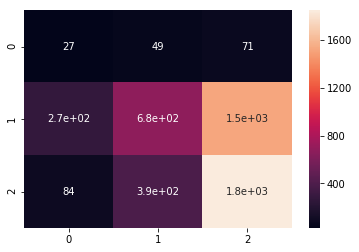

In [69]:
generate_classification_report(TEXTCNN_WITH_TABULAR_MODEL,
                               VALIDATION_DATAFRAME,
                               (VALIDATION_DESCRIPTIONS_NO_BIGRAMS,
                                VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                               VALIDATION_LABELS.values,
                               [0, 1, 2])

In [70]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns(
        TEXTCNN_WITH_TABULAR_MODEL,
        FEATURES_TEST_DATAFRAME['listing_id'],
        (TEST_DESCRIPTIONS_NO_BIGRAMS,
         TEST_FEATURES_CONTINUOUS_TENSOR,
         TEST_FEATURES_CATEGORICAL_TENSOR),
        
    ),
    'textcnn_tabular_model_submissions.csv'
)

### 3.3.4 BERT)

BERT is a big ol' attentional model.

We use the pretrained version of BERT (eg `bert-base-uncased`) and the
corresponding tokenizer - `bert_featurize_dataframe` reads from
`clean_description` in the dataframe and tokenizes sentences in the
same way that the pre-trained model was tokenized and should in principle
do the word vector mapping for us.

Essentially what we are doing here is fine-tuning the classification
layers of BERT.

In [35]:
(TRAIN_BERT_LANG_FEATURES,
 VALIDATION_BERT_LANG_FEATURES,
 TEST_BERT_LANG_FEATURES) = bert_featurize_data_frames(
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME
)

01/21/2019 12:27:14 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /u/77/spilsbt1/unix/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [36]:
TRAIN_BERT_LANG_FEATURES_TENSOR = tuple(torch.stack(x) for x in zip(*TRAIN_BERT_LANG_FEATURES))
VALIDATION_BERT_LANG_FEATURES_TENSOR = tuple(torch.stack(x) for x in zip(*VALIDATION_BERT_LANG_FEATURES))
TEST_BERT_LANG_FEATURES_TENSOR = tuple(torch.stack(x) for x in zip(*TEST_BERT_LANG_FEATURES))

In [37]:
TRAIN_BERT_FEATURES_TENSOR = tuple(torch.stack(x) for x in zip(*[
    tuple(list(bert_features) + [categorical, continuous])
    for bert_features, categorical, continuous in zip(TRAIN_BERT_LANG_FEATURES,
                                                      TRAIN_FEATURES_CATEGORICAL_TENSOR,
                                                      TRAIN_FEATURES_CONTINUOUS_TENSOR)
]))
VALIDATION_BERT_FEATURES_TENSOR = tuple(torch.stack(x) for x in zip(*[
    tuple(list(bert_features) + [categorical, continuous])
    for bert_features, categorical, continuous in zip(VALIDATION_BERT_LANG_FEATURES,
                                                      VALIDATION_FEATURES_CATEGORICAL_TENSOR,
                                                      VALIDATION_FEATURES_CONTINUOUS_TENSOR)
]))
TEST_BERT_FEATURES_TENSOR = tuple(torch.stack(x) for x in zip(*[
    tuple(list(bert_features) + [categorical, continuous])
    for bert_features, categorical, continuous in zip(TEST_BERT_LANG_FEATURES,
                                                      TEST_FEATURES_CATEGORICAL_TENSOR,
                                                      TEST_FEATURES_CONTINUOUS_TENSOR)
]))

In [74]:
EPOCHS = 10
NUM_TRAIN_STEPS = int(len(TRAIN_BERT_LANG_FEATURES) / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * EPOCHS)
BERT_LANG_MODEL = BertClassifier(
    module=create_bert_model(
        3
    ),
    optimizer__warmup=WARMUP_PROPORTION,
    optimizer__t_total=NUM_TRAIN_STEPS,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    optimizer=BertAdam,
    lr=LEARNING_RATE,
    num_train_steps=NUM_TRAIN_STEPS,
    num_labels=3,
    batch_size=TRAIN_BATCH_SIZE,
    train_split=shuffled_train_test_split_by_indices(0.3),
    callbacks=[
        EpochScoring(scoring='accuracy'),
        ProgressBar(),
        CheckpointAndKeepBest(dirname='bert_lang_checkpoint'),
        TrainEndCheckpoint(dirname='bert_lang_checkpoint',
                           fn_prefix='bert_tabular_train_end_')
    ],
)

01/21/2019 09:50:47 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /u/77/spilsbt1/unix/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
01/21/2019 09:50:47 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /u/77/spilsbt1/unix/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpn78zh2_3
01/21/2019 09:50:50 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_v

In [76]:
BERT_LANG_MODEL.fit(TRAIN_BERT_LANG_FEATURES_TENSOR,
                    TRAIN_LABELS_TENSOR)

Re-initializing optimizer because the following parameters were re-set: t_total, warmup.


  epoch    accuracy    train_loss    valid_acc    valid_loss    cp       dur
-------  ----------  ------------  -----------  ------------  ----  --------
      1      0.6955        0.7779       0.6955        0.7659     +  506.6275


      2      0.6955        0.7726       0.6955        0.7815        513.1247


      3      0.6955        0.7844       0.6955        0.7798        507.2884


      4      0.6955        0.7827       0.6955        0.7787        508.5916


      5      0.6955        0.7829       0.6955        0.7787        507.1037


      6      0.6955        0.7817       0.6955        0.7775        504.0017


      7      0.6955        0.7810       0.6955        0.7774        504.1600


      8      0.6955        0.7814       0.6955        0.7777        503.8552


      9      0.6955        0.7812       0.6955        0.7780        503.7747


     10      0.6955        0.7814       0.6955        0.7777        514.1087
Loading parameters from checkpoint 0


<class 'utils.language_models.bert.BertClassifier'>[initialized](
  module_=BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): BertLayerNorm()
        (dropout): Dropout(p=0.1)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): B

Label was 0, classified as 0


,description,price,bedrooms,bathrooms,photos_count


Label was 0, classified as 1


,description,price,bedrooms,bathrooms,photos_count


Label was 0, classified as 2


,description,price,bedrooms,bathrooms,photos_count
2,5TH ST/ 2 AVE! RENOVATED 2 BEDROOM IN CHARMING...,3200,2,1.0,6
9,83RD/ AMSTERDAM! TRUE 2 BED IN NICE WELL KEPT ...,3000,2,1.0,6
46,Gorgeous Renovated Studio apartment in Kew Gar...,1375,0,1.0,7
47,Simply amazing!!!! Spacious 3 bedroom apartmen...,1899,3,1.0,8
69,Spacious studio apartment near Fulton Street M...,2495,0,1.0,5


Label was 1, classified as 0


,description,price,bedrooms,bathrooms,photos_count


Label was 1, classified as 1


,description,price,bedrooms,bathrooms,photos_count


Label was 1, classified as 2


,description,price,bedrooms,bathrooms,photos_count
17,Residential Prewar Building With Art Deco Flai...,2995,2,1.0,4
23,Charming 1 Bedroom Apartment for Rent in Boeru...,2500,1,1.0,12
24,LISTING ID: 150804\rSunny apartment in a quiet...,2050,1,1.0,3
31,Prime Murray Hill Neighborhood! Located off ...,2350,0,1.0,2
34,This bright 1 bedroom apartment is located jus...,2100,1,1.0,5


Label was 2, classified as 0


,description,price,bedrooms,bathrooms,photos_count


Label was 2, classified as 1


,description,price,bedrooms,bathrooms,photos_count


Label was 2, classified as 2


,description,price,bedrooms,bathrooms,photos_count
0,THE PRICE IS NET EFFECTIVE - One month Free on...,2900,1,1.0,4
1,Spacious and contemporary alcove studio with h...,4000,0,1.0,4
3,85TH/ 3 AVE! UNIQUE 800 SQFT PENTHOUSE DUPLEX ...,2850,1,2.0,6
4,This HUGE STUDIO LOFT apartment HAS AN AMAZING...,3100,0,1.0,5
5,"Located on west 57th st , short walk from Colu...",4000,2,1.0,6


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.70      0.82      4936

   micro avg       0.70      0.70      0.70      4936
   macro avg       0.33      0.23      0.27      4936
weighted avg       1.00      0.70      0.82      4936

Logistic loss 0.76142


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


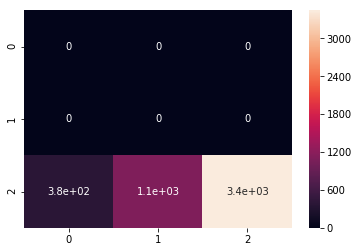

In [77]:
generate_classification_report(BERT_LANG_MODEL,
                               VALIDATION_DATAFRAME,
                               VALIDATION_BERT_LANG_FEATURES_TENSOR,
                               VALIDATION_LABELS.values,
                               [0, 1, 2])

In [78]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns(
        BERT_LANG_MODEL,
        FEATURES_TEST_DATAFRAME['listing_id'],
        TEST_BERT_LANG_FEATURES_TENSOR,
    ),
    'bert_model_submissions.csv'
)

In [38]:
EPOCHS = 10
NUM_TRAIN_STEPS = int(len(TRAIN_BERT_LANG_FEATURES) / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * EPOCHS)
BERT_TABULAR_MODEL = BertClassifier(
    module=create_bert_model_with_tabular_features(
        TRAIN_FEATURES_CONTINUOUS.shape[1],
        [
            (max(TRAIN_FEATURES_CATEGORICAL[:,c]) + 1, 80)
            for c in range(TRAIN_FEATURES_CATEGORICAL.shape[1])
        ],
        3
    ),
    callbacks=[
        EpochScoring(scoring='accuracy'),
        ProgressBar(),
        CheckpointAndKeepBest(dirname='bert_tabular_checkpoint'),
        TrainEndCheckpoint(dirname='bert_tabular_checkpoint',
                           fn_prefix='bert_tabular_train_end_')
    ],
    optimizer=BertAdam,
    lr=LEARNING_RATE,
    num_train_steps=NUM_TRAIN_STEPS,
    num_labels=3,
    batch_size=TRAIN_BATCH_SIZE,
    train_split=ordered_train_test_split_with_oversampling(0.3),
    optimizer__warmup=WARMUP_PROPORTION,
    optimizer__t_total=NUM_TRAIN_STEPS,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

01/21/2019 12:29:54 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /u/77/spilsbt1/unix/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
01/21/2019 12:29:54 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /u/77/spilsbt1/unix/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpbuz70fsy
01/21/2019 12:29:57 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_v

In [39]:
BERT_TABULAR_MODEL.fit(TRAIN_BERT_FEATURES_TENSOR,
                       TRAIN_LABELS_TENSOR)

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp        dur
-------  ----------  ------------  -----------  ------------  ----  ---------
      1      0.6534        1.0886       0.6534        0.8929     +  1007.4100


      2      0.6402        0.9877       0.6402        0.8278     +  1007.0459


      3      0.6451        0.8057       0.6451        0.8282        1003.8262


      4      0.6581        0.6100       0.6581        0.9030        988.6089


      5      0.6546        0.5114       0.6546        0.9757        1005.7873


Loading parameters from checkpoint 1


<class 'utils.language_models.bert.BertClassifier'>[initialized](
  module_=BertForSequenceClassificationWithTabularData(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): BertLayerNorm()
        (dropout): Dropout(p=0.1)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
               

In [ ]:
generate_classification_report(BERT_TABULAR_MODEL,
                               VALIDATION_DATAFRAME,
                               VALIDATION_BERT_FEATURES_TENSOR,
                               VALIDATION_LABELS.values,
                               [0, 1, 2])

In [41]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns(
        BERT_TABULAR_MODEL,
        FEATURES_TEST_DATAFRAME['listing_id'],
        TEST_BERT_FEATURES_TENSOR,
    ),
    'bert_tabular_model_submissions.csv'
)

### ULMFiT
This is basically transfer learning onto an AWD-LSTM (used by fastai).

We have to use the fastai API here directly, since the best
implementation I found of this was by Jeremy Howard himself.

Note before we ran the notebook, we used `train_lm.py` (pointing it
to the training data) to fine-tune the existing language model,
which in principle is good at English (WikiText-103) and made transferred
what we knew about English word prediction to predicting RentHop
descriptions, fine tuning on the RentHop description task. This is
different from just using word vectors, since you get the benefit
of the entire language model and contextual information, not just
the vectors themselves.

It is critical here that we load the same vocabulary used to fine
tune the network into the model when we load in the weights. Also,
we need to do the train-test split ourselves, because there
is a bug in the library where the vocabulary is only computed
on the training set and not the validation set, meaning that if the
splits are random you could miss words.

Unfortunately, the fastai API is very involved, making it difficult
to wrap with skortch without breaking stuff, so we have to use it
in a slightly different way to do the same thing. We can also only
report statistics on the first batch, hopefully that should be enough.

In [42]:
with open('vocab.pkl', 'rb') as vocab_f:
    ULMFIT_LANGUAGE_MODEL_VOCABULARY = pickle.load(vocab_f)

ULMFIT_LEARNER = load_ulmfit_classifier_with_transfer_learning_from_data_frame(
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
    ULMFIT_LANGUAGE_MODEL_VOCABULARY,
    'renthop_ulmfit',
    'fine_tuned_renthop'
)

In [43]:
train_ulmfit_classifier_with_gradual_unfreezing(ULMFIT_LEARNER, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.775524,0.773560,0.685575
2,0.755109,0.772267,0.687601


epoch,train_loss,valid_loss,accuracy
1,0.773798,0.741369,0.691653


epoch,train_loss,valid_loss,accuracy


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [44]:
ULMFIT_LEARNER.fit_one_cycle(10,
                             slice((1e-2 / 10) / (2.6 ** 4),
                                   1e-2 / 10),
                             moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.717749,0.729675,0.696313
2,0.719705,0.736379,0.697123
3,0.731112,0.731291,0.696921
4,0.749117,0.732700,0.693882
5,0.704555,0.725013,0.699149
6,0.740856,0.734320,0.697326


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [46]:
ULMFIT_VAL_DATA, ULMFIT_VAL_LABELS = next(iter(ULMFIT_LEARNER.data.valid_dl))
ULMFIT_RECONSTRUCTED_VAL_DATA = pd.DataFrame([
    ULMFIT_LEARNER.data.valid_ds.reconstruct(d) for d in ULMFIT_VAL_DATA
], columns=['description'])

In [47]:
ULMFIT_VALID_PREDS = ULMFIT_LEARNER.get_preds(ds_type='valid', n_batch=1)

In [48]:
ULMFIT_TEST_PREDS = ULMFIT_LEARNER.get_preds(ds_type='test')

Label was 0, classified as 0


,description
8,xxbos ( ( no broker fee ) ) new new new ! be t...


Label was 0, classified as 1


,description


Label was 0, classified as 2


,description


Label was 1, classified as 0


,description


Label was 1, classified as 1


,description
1,xxbos grand upper bedroom bath duplex with exc...
13,"xxbos beautifully renovated bedroom , bath res..."
26,xxbos take a deep breath of relaxation the mom...
32,xxbos analyze this ! take a quick preview of t...


Label was 1, classified as 2


,description
7,xxbos this story luxury high rise offers studi...
9,xxbos shown by appointment . please contact ca...
16,xxbos analyze this ! take a quick preview of t...
17,xxbos analyze this ! take a quick preview of t...
25,xxbos gorgeous large studio in a luxury hr dm ...


Label was 2, classified as 0


,description
11,xxbos one month free with two a year lease at ...


Label was 2, classified as 1


,description
3,"xxbos within its handsome , industrial inspire..."
12,xxbos sweeping river and city views on the upp...
18,xxbos welcome to metropolitan ! this new devel...
28,"xxbos amenities dishwasher , renovateddescript..."


Label was 2, classified as 2


,description
0,"xxbos the new crown jewel of manhattan , the b..."
2,xxbos welcome home to an awesome . bedroom apa...
4,xxbos available now must see no brokers fee+ m...
5,xxbos this substantial one bedroom one bathroo...
6,"xxbos welcome to bedford , williamsburg 's new..."


              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.36      0.50      0.42         8
           2       0.86      0.82      0.84        38

   micro avg       0.75      0.75      0.75        48
   macro avg       0.74      0.61      0.64        48
weighted avg       0.78      0.75      0.76        48

Logistic loss 0.65799


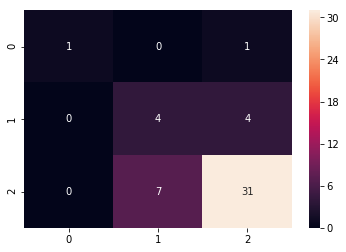

In [52]:
ULMFIT_PROBABILITIES, ULMFIT_PREDICTIONS = ULMFIT_VALID_PREDS
generate_classification_report_from_preds(ULMFIT_PREDICTIONS.cpu().numpy(),
                                          ULMFIT_PROBABILITIES.cpu().numpy(),
                                          ULMFIT_RECONSTRUCTED_VAL_DATA,
                                          ULMFIT_VAL_LABELS.cpu().numpy(),
                                          [0, 1, 2],
                                          columns=['description'])

In [57]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        ULMFIT_TEST_PREDS[0].cpu().numpy()
    ),
    'ulmfit_submissions.csv'
)

### Ensembling

Now that we have all of our models and various predictions, we can
ensemble them together in the form of one big gradient boosted tree to work out what the "true" classes are based on how all the different models were voting.

Notice that the confusion matrix for each of the models was quite
different - this indicates that each model is probably more biased towards certain features. We can get the predictions for all
of our training data and put them together into another dataset which we then apply XGBoost to. In principle this allows us to decide which learner best 